In [1]:
#import os
# point to durga GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-f80e9374-504a-571b-bac0-6fb00750db4c"
# point to nandi GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [164]:
import numpy as np
import pandas as pd
from collections import defaultdict
import gzip
from tqdm import tqdm
import pyBigWig
from pyfaidx import Fasta
import subprocess
import sys
import os


model_cell_type = "K562"

timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]

in_window = 2114
out_window = 1000


# filepaths

proj_dir = "/mnt/lab_data2/kcochran/procapnet/"
genome_path = proj_dir + "genomes/hg38.withrDNA.fasta"
chrom_sizes = proj_dir + "genomes/hg38.withrDNA.chrom.sizes"

all_procap_peak_path = proj_dir + "data/procap/processed/" + model_cell_type + "/peaks.bed.gz"
plus_bw_path = proj_dir + "data/procap/processed/" + model_cell_type + "/5prime.pos.bigWig"
minus_bw_path = proj_dir + "data/procap/processed/" + model_cell_type + "/5prime.neg.bigWig"

plus_preds_bw_path = "tracks_v2/TSS_windows.preds.pos.bigWig"
minus_preds_bw_path = "tracks_v2/TSS_windows.preds.neg.bigWig"

prof_shap_bw_path = "tracks_v2/TSS_windows.scores.prof.bigWig"
counts_shap_bw_path = "tracks_v2/TSS_windows.scores.counts.bigWig"

genes_list_path = "genes_to_screen.csv"  # from Shreya

candidate_promoter_regions_bed = "TSS_windows.smaller.merge.bed"  # smaller regions so they're less enormous

other_data_dir = "bassik_collab_data/"
os.makedirs(other_data_dir, exist_ok=True)

dnase_bw_path = other_data_dir + "dnase.macrophage.bigWig"
dnase_preds_bw_path = other_data_dir + "dnase.macrophage.chrombpnet.preds.bigWig"
dnase_prof_shap_bw_path = other_data_dir + "dnase.macrophage.chrombpnet.shap.profile.bigWig"
dnase_counts_shap_bw_path = other_data_dir + "dnase.macrophage.chrombpnet.shap.counts.bigWig"

all_bw_paths = {"procap" : {"obs_data" : {"+" : plus_bw_path, "-" : minus_bw_path},
                            "preds" : {"+" : plus_preds_bw_path, "-" : minus_preds_bw_path},
                            "scores" : {"profile" : prof_shap_bw_path, "counts" : counts_shap_bw_path}},
                "dnase"  : {"obs_data" : dnase_bw_path,
                            "preds" : dnase_preds_bw_path,
                            "scores" : {"profile" : dnase_prof_shap_bw_path, "counts" : dnase_counts_shap_bw_path}}}

In [3]:
# only need to run once: download Ziwei's chrombpnet tracks

! wget https://mitra.stanford.edu/kundaje/oak/projects/chromatin-atlas-2022/DNASE/ENCSR721XAP/preprocessing/bigWigs/ENCSR721XAP.bigWig -O $dnase_bw_path
! wget https://mitra.stanford.edu/kundaje/oak/ziwei75/collab_bassik/macrophage_promoter/output/ENCSR721XAP_prediction.bw -O $dnase_preds_bw_path
! wget https://mitra.stanford.edu/kundaje/oak/ziwei75/collab_bassik/macrophage_promoter/output/ENCSR721XAP_profile_shap.bw -O $dnase_prof_shap_bw_path
! wget https://mitra.stanford.edu/kundaje/oak/ziwei75/collab_bassik/macrophage_promoter/output/ENCSR721XAP_count_shap.bw -O $dnase_counts_shap_bw_path


--2024-02-14 05:43:03--  https://mitra.stanford.edu/kundaje/oak/projects/chromatin-atlas-2022/DNASE/ENCSR721XAP/preprocessing/bigWigs/ENCSR721XAP.bigWig
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 989152938 (943M)
Saving to: ‘dnase.macrophage.bigWig’

dnase.macrophage.bi 100%[===================>] 943.33M  71.7MB/s    in 11s     

2024-02-14 05:43:14 (84.7 MB/s) - ‘dnase.macrophage.bigWig’ saved [989152938/989152938]

--2024-02-14 05:43:23--  https://mitra.stanford.edu/kundaje/oak/ziwei75/collab_bassik/macrophage_promoter/output/ENCSR721XAP_prediction.bw
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11854098 (11M)
Saving to: ‘dnase.macrophage.chrombpnet.preds.bigW

## Load Promoter Regions

In [2]:
# load Shreya's gene list

def load_genes_to_screen(csv_path):
    df = pd.read_csv(csv_path, sep=",")
    return list(df["gene_name"])
    
gene_names = load_genes_to_screen(genes_list_path)

print(gene_names)

['MT-RNR1', 'PJA2', 'MYO15B', 'MRFAP1', 'SCAMP4', 'PLXND1', 'IPO7', 'CNOT1', 'DAZAP2', 'RN7SL1', 'CROCCP2', 'ATP6AP1', 'PPIA', 'ARAP1', 'TLN1', 'NEAT1', 'MTATP6P1', 'PRKDC', 'MTMR9LP', 'ATP5F1B', 'LENG8', 'THUMPD3-AS1', 'RCC1L', 'SRRM2', 'HNRNPF', 'MALAT1', 'LSM14A', 'CAPZA2', 'MTCO1P12', 'NCKAP1L', 'RNPS1', 'REPIN1', 'CAPNS1', 'ZNF407-AS1', 'CLTC', 'TMX2', 'GNA13', 'RBM12', 'PTMS', 'PILRA', 'ACACA', 'RAB31', 'MYO5A', 'DCTN1', 'CCNL2', 'ATXN7L3B', 'ZBTB7A', 'RANBP2', 'ARPC5', 'DENND4B', 'RHOA', 'RBM14', 'VPS52', 'G3BP1', 'SEPTIN2', 'SNX3', 'DCLRE1A', 'EP400', 'WBP2', 'EIF3A', 'TAF9', 'PFKL', 'SF1', 'JUND', 'NOL7', 'TMEM259', 'FNIP1', 'STK40', 'RAB11B', 'SET', 'ATP6V1C1', 'AGRN', 'HNRNPU', 'SF3B1', 'ARF6', 'HNRNPH1', 'HCLS1', 'CICP14', 'DOCK2', 'ZNF8', 'ILF3', 'ACADVL', 'ZNHIT3', 'TADA2A']


In [165]:
# load regions defined in previous notebook

! head $candidate_promoter_regions_bed

chr1	630574	631574	MTCO1P12	.	+
chr1	633196	634196	MTATP6P1	.	+
chr1	1019620	1020623	AGRN	.	+
chr1	1033606	1035367	AGRN	.	+
chr1	1044899	1045899	AGRN	.	+
chr1	1046701	1047975	AGRN	.	+
chr1	1048029	1049029	AGRN	.	+
chr1	1051486	1052486	AGRN	.	+
chr1	1388213	1389213	CCNL2	.	-
chr1	1390400	1393216	CCNL2	.	-


In [167]:
! wc -l $candidate_promoter_regions_bed

347 TSS_windows.smaller.merge.bed


In [166]:
def load_coords(bed_path):
    lines = []
    if bed_path.endswith(".gz"):
        with gzip.open(bed_path) as f:
            lines = [line.decode().strip().split() for line in f]
    else:
        with open(bed_path) as f:
            lines = [line.strip().split() for line in f]
    
    coords = [(line[0], int(line[1]), int(line[2]), line[3], line[-1]) for line in lines]
    return coords

promoter_coords = load_coords(candidate_promoter_regions_bed)

In [168]:
promoter_coords

[('chr1', 630574, 631574, 'MTCO1P12', '+'),
 ('chr1', 633196, 634196, 'MTATP6P1', '+'),
 ('chr1', 1019620, 1020623, 'AGRN', '+'),
 ('chr1', 1033606, 1035367, 'AGRN', '+'),
 ('chr1', 1044899, 1045899, 'AGRN', '+'),
 ('chr1', 1046701, 1047975, 'AGRN', '+'),
 ('chr1', 1048029, 1049029, 'AGRN', '+'),
 ('chr1', 1051486, 1052486, 'AGRN', '+'),
 ('chr1', 1388213, 1389213, 'CCNL2', '-'),
 ('chr1', 1390400, 1393216, 'CCNL2', '-'),
 ('chr1', 1397787, 1399835, 'CCNL2', '-'),
 ('chr1', 16625886, 16626886, 'CROCCP2', '-'),
 ('chr1', 16628152, 16629152, 'CROCCP2', '-'),
 ('chr1', 16630609, 16631609, 'CROCCP2', '-'),
 ('chr1', 16644172, 16645186, 'CROCCP2', '-'),
 ('chr1', 16656732, 16657732, 'CROCCP2', '-'),
 ('chr1', 32239747, 32242210, 'MTMR9LP', '-'),
 ('chr1', 36360840, 36361840, 'STK40', '-'),
 ('chr1', 36362156, 36363156, 'STK40', '-'),
 ('chr1', 36365572, 36366572, 'STK40', '-'),
 ('chr1', 36385376, 36386424, 'STK40', '-'),
 ('chr1', 153932220, 153933765, 'DENND4B', '-'),
 ('chr1', 153936142,

In [174]:
# example to start with
promoter_coords[301], len(promoter_coords)

(('chr5', 179622633, 179625169, 'HNRNPH1', '-'), 347)

## Find Boundaries

In [175]:
chrom, start, end = promoter_coords[301][:3]

In [176]:
import sys
sys.path.append("../2_train_models")

from data_loading import read_fasta_fast, one_hot_encode

# need to convert bigwig-stored attributions to plottable base scores

def load_sequence_at_locus(chrom, start, end, genome_path):
    seq_start = start - (in_window - out_window) // 2
    seq_end = end + (in_window - out_window) // 2
    
    genome = read_fasta_fast(genome_path, include_chroms = [chrom])
    seq = genome[chrom][start:end]
    onehot_seq = one_hot_encode(seq).T
    return onehot_seq

onehot_seq = load_sequence_at_locus(chrom, start, end, genome_path)

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


In [177]:
import pyBigWig

def load_bw_data_at_locus(chrom, start, end, bw_path):
    assert os.path.exists(bw_path), bw_path
        
    with pyBigWig.open(bw_path, "r") as bw:
        signal = bw.values(chrom, start, end, numpy=True)

    return np.nan_to_num(signal)


def load_all_data_for_locus(chrom, start, end, bw_paths_dict):
    loaded_data = dict()
    for data_type, bw_path_or_paths in bw_paths_dict.items():
        if type(bw_path_or_paths) == str:
            loaded_data[data_type] = load_bw_data_at_locus(chrom, start, end, bw_path_or_paths)
        else:
            inner_dict = dict()
            for subtype, bw_path in bw_path_or_paths.items():
                inner_dict[subtype] = load_bw_data_at_locus(chrom, start, end, bw_path)
                
            if inner_dict.keys() == set(["+", "-"]):
                two_stranded_array = np.array([inner_dict["+"], inner_dict["-"]])
                loaded_data[data_type] = two_stranded_array
            else:
                loaded_data[data_type] = inner_dict
    return loaded_data


dnase_data = load_all_data_for_locus(chrom, start, end, all_bw_paths["dnase"])
procap_data = load_all_data_for_locus(chrom, start, end, all_bw_paths["procap"])

In [178]:
dnase_data

{'obs_data': array([0., 0., 1., ..., 0., 0., 1.], dtype=float32),
 'preds': array([0.4266324 , 0.4541052 , 0.6344553 , ..., 0.06332039, 0.06004984,
        0.06116425], dtype=float32),
 'scores': {'profile': array([ 1.0934516e-03,  8.8477018e-04, -3.3441847e-05, ...,
         -7.3733117e-04, -6.6139526e-04,  6.0434680e-04], dtype=float32),
  'counts': array([ 5.1032985e-06, -5.4567592e-04, -1.1168648e-03, ...,
          9.8657683e-06, -2.1479159e-04, -9.7981503e-04], dtype=float32)}}

In [179]:
procap_data

{'obs_data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'preds': array([[0.01105456, 0.0195548 , 0.19507995, ..., 0.00713707, 0.07689259,
         0.00296685],
        [0.04162494, 0.19288924, 0.05090585, ..., 0.03425945, 0.00272414,
         0.00901209]], dtype=float32),
 'scores': {'profile': array([ 0.00071963,  0.00078706,  0.00064585, ...,  0.00062356,
          0.0010252 , -0.0001855 ], dtype=float32),
  'counts': array([-0.00183217, -0.00172943, -0.00242709, ..., -0.00048546,
         -0.00050655, -0.00035751], dtype=float32)}}

In [180]:
import logomaker
import matplotlib.patches as patches


def add_ylabel_to_axis(label, ax):
    ax.set_ylabel(label, fontsize = 7, rotation=0,
                  labelpad=4, ha='right', va="center")

    
def plot_prof_on_ax(profile_array, ax, ylabel = None,
                    color = "#001DAC"):
    
    linewidth = 1
    
    profile_array = profile_array.squeeze()
    
    assert profile_array.shape[-1] == max(profile_array.shape), profile_array.shape
    prof_len = profile_array.shape[-1]  
    x_range = np.arange(0, prof_len) + 0.5
    
    if len(profile_array.shape) == 1:
        ax.plot(x_range, profile_array,
                alpha = 1, c = color, linewidth = linewidth)
    else:
        x_offset = np.max(np.abs(profile_array)) * 0.02
        
        ax.plot(x_range, profile_array[0] + x_offset,
                alpha = 1, c = color, linewidth = linewidth)
        ax.plot(x_range, -1 * profile_array[1] - x_offset,
                alpha = 0.7, c = color, linewidth = linewidth)
    
    ax.set_xlim(0, prof_len)
    
    if ylabel:
        add_ylabel_to_axis(ylabel, ax)
        

def plot_motif_on_ax(array, ax, ylabel = None):
    assert len(array.shape) == 2, array.shape
    
    if array.shape[-1] != 4:
        if array.shape[0] == 4:
            array = array.T
        else:
            assert False, ("Array shape broken", array.shape)
    
    # reformat pwm to what logomaker expects
    df = pd.DataFrame(array, columns=['A', 'C', 'G', 'T'])
    df.index.name = 'pos'

    # plot motif ("baseline_width=0" removes the y=0 line)
    logo = logomaker.Logo(df, ax=ax, font_name='Arial Rounded', baseline_width=0)
    
    # fix appearance to be less terrible
    logo.style_spines(visible=False)
    ax.set_ylim(min(df.sum(axis=1).min(), 0), df.sum(axis=1).max())
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    ax.set_xlim(0, max(array.shape))
    
    if ylabel:
        add_ylabel_to_axis(ylabel, ax)
    
    
def plot_tracks_for_expt(data_dict, onehot_seq, axes, expt_name, attrs_as_seqs = False):
    plot_prof_on_ax(data_dict["obs_data"], axes[0],
                    ylabel = "Observed\n" + expt_name, color = "#001DAC")

    plot_prof_on_ax(data_dict["preds"], axes[1],
                    ylabel = "Predicted\n" + expt_name, color = "#1B5AE3")

    if attrs_as_seqs:
        plot_motif_on_ax(data_dict["scores"]["profile"] * onehot_seq, axes[2],
                         ylabel = expt_name + "\nProfile Scores")

        plot_motif_on_ax(data_dict["scores"]["counts"] * onehot_seq, axes[3],
                         ylabel = expt_name + "\nCounts Scores")
    else:
        plot_prof_on_ax(data_dict["scores"]["profile"], axes[2],
                        ylabel = expt_name + "\nProfile Scores", color = "darkmagenta")

        plot_prof_on_ax(data_dict["scores"]["counts"], axes[3],
                        ylabel = expt_name + "\nCounts Scores", color = "darkmagenta")


def erase_axis(axis):
    axis.spines[["left", "right", "top", "bottom"]].set_visible(False)
    axis.set_xticks([])
    axis.set_yticks([])

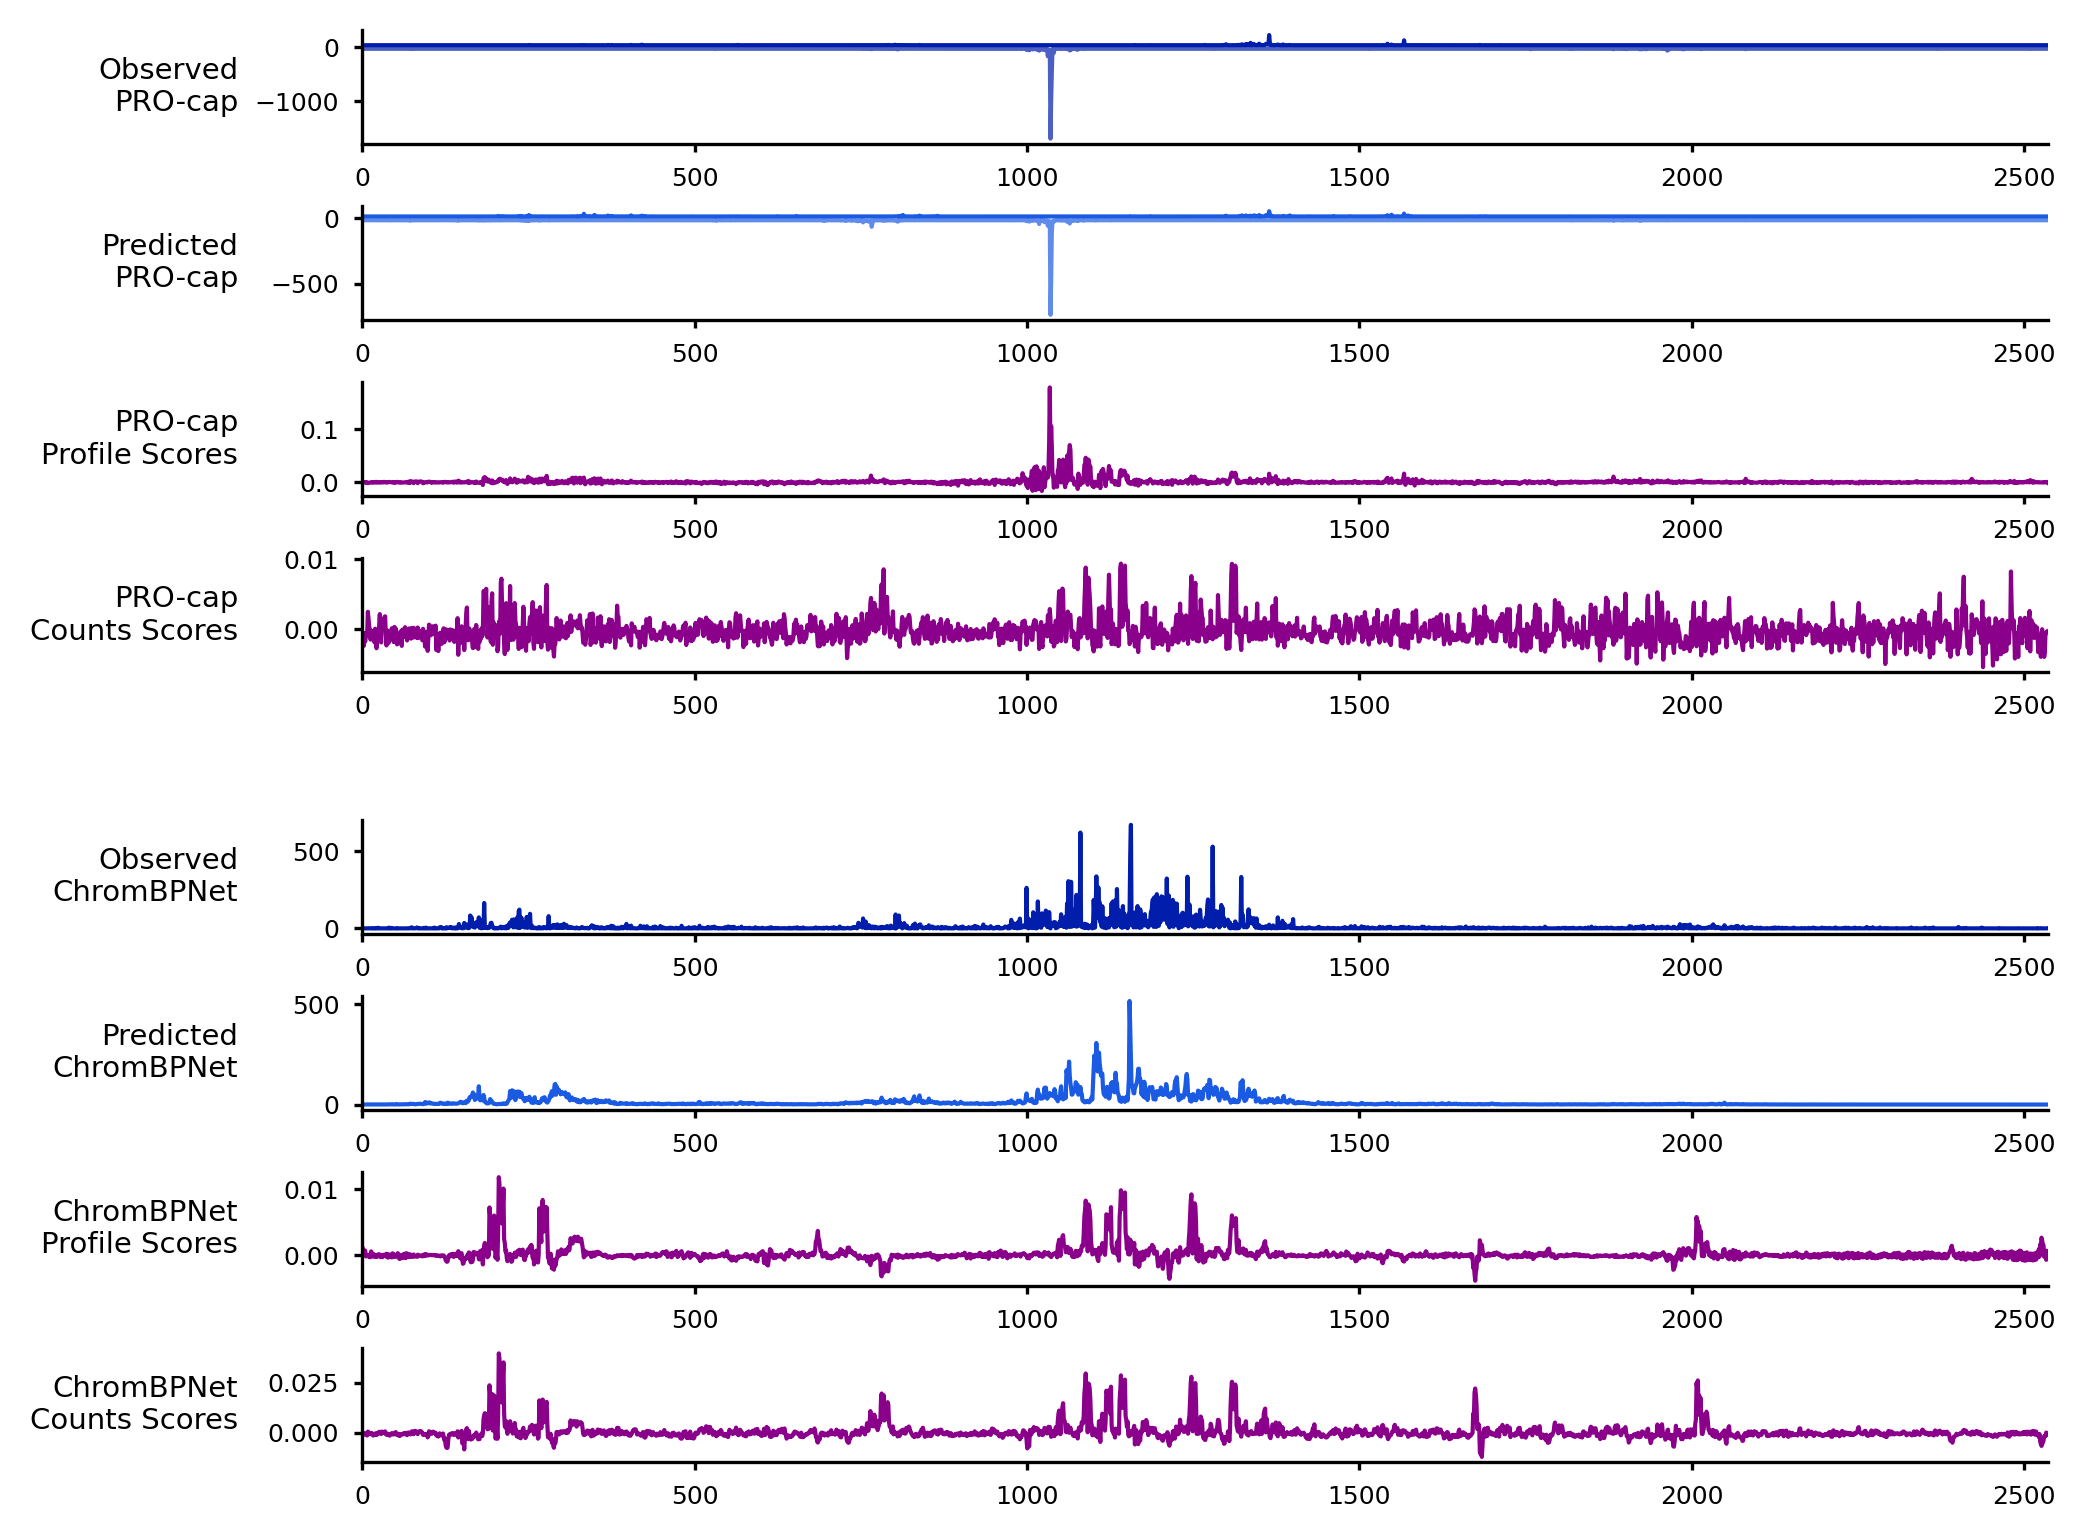

In [206]:
fig = plt.figure(figsize=(7.25, 6.2), dpi=300)
gs = fig.add_gridspec(9, height_ratios = [10] * 4 + [2] + [10] * 4, hspace=0.6)
axes = gs.subplots()


plot_tracks_for_expt(procap_data, onehot_seq, axes[:4], "PRO-cap")
plot_tracks_for_expt(dnase_data, onehot_seq, axes[5:], "ChromBPNet")
    
for ax_i, ax in enumerate(axes):
    ax.tick_params(length=2, labelsize=6)
    ax.spines[["top", "right"]].set_visible(False)
    
erase_axis(axes[4])
    
fig.align_ylabels()

plt.show()

In [370]:
def convolve(array, conv_width = 1):
    array_after_conv = array.copy()
    
    for index in np.arange(conv_width, len(array) - conv_width):
        to_conv = array[index - conv_width : index + conv_width]
        array_after_conv[index] = np.mean(to_conv)
        
    assert array_after_conv.shape == array.shape
    return array_after_conv


def convert_bases_above_thresh_to_bounds(indexes_above_thresh, locus_len, min_dist_between_bounds = 50):
    windows_of_bases_below_thresh = []
    
    if indexes_above_thresh[0] - 1 >= min_dist_between_bounds:
        window = (0, indexes_above_thresh[0] - 1)
        windows_of_bases_below_thresh.append(window)
    
    for i in range(1, len(indexes_above_thresh)):
        dist_between_bases = indexes_above_thresh[i] - indexes_above_thresh[i - 1]
        
        if dist_between_bases >= min_dist_between_bounds:
            window = (indexes_above_thresh[i - 1] + 1, indexes_above_thresh[i] - 1)
            windows_of_bases_below_thresh.append(window)
            
    if locus_len - indexes_above_thresh[-1] + 1 >= min_dist_between_bounds:
        window = (indexes_above_thresh[-1] + 1, locus_len)
        windows_of_bases_below_thresh.append(window)
    
            
    # then invert windows
    windows_of_bases_above_thresh = []
    
    if windows_of_bases_below_thresh[0][0] != 0:
        new_window = (min(indexes_above_thresh), windows_of_bases_below_thresh[0][0] - 1)
        windows_of_bases_above_thresh.append(new_window)
    
    for i in range(1, len(windows_of_bases_below_thresh)):
        end_of_previous_window = windows_of_bases_below_thresh[i - 1][1]
        start_of_next_window = windows_of_bases_below_thresh[i][0]
        
        inverted_window = (end_of_previous_window + 1, start_of_next_window - 1)
        windows_of_bases_above_thresh.append((inverted_window))
        
    if windows_of_bases_below_thresh[-1][1] != locus_len:
        new_window = (max(indexes_above_thresh) + 1, windows_of_bases_below_thresh[-1][1])
        windows_of_bases_above_thresh.append(new_window)
        
    return windows_of_bases_above_thresh
    

def draw_base_label(start_pos, locus_len, ymax):
    rect = patches.Rectangle((start_pos, 0), 1, ymax,
                             linewidth=1, edgecolor='yellow', facecolor='yellow', alpha=0.03)
    plt.gca().add_patch(rect)
    

def calc_bounds(obs_dnase, conv_width = 25, frac_of_max_thresh = 0.1):
    locus_len = len(obs_dnase)
    conv_data = convolve(obs_dnase, conv_width = conv_width)
    
    # set threshold to be X fraction of the max signal
    # (ex: we want to keep all bases with at least 5% of the max signal)
    
    thresh = np.max(conv_data) * frac_of_max_thresh
    
    bases_above_thresh = conv_data > thresh
    indexes_above_thresh = np.where(bases_above_thresh)[0]
    assert len(indexes_above_thresh > 0)

    # figure out what mini-regions of contiguous bases do a good job
    # of covering all the bases above threshold
    
    bounds_windows = convert_bases_above_thresh_to_bounds(indexes_above_thresh, locus_len)
    
    # then report results
    
    num_bounds_windows = len(bounds_windows)
    print("Found " + str(num_bounds_windows) + " windows that cover signal:")
    for window_i, (bounds_window_start, bounds_window_end) in enumerate(bounds_windows):
        print("Window " + str(window_i + 1) + ":", bounds_window_start, "to", bounds_window_end)
    print()
    
    overall_bounds = min(indexes_above_thresh), max(indexes_above_thresh)
    
    print("Bounds containing all windows:", overall_bounds[0], overall_bounds[1])
    print("Length of region containing all windows:", overall_bounds[1] - overall_bounds[0])
    print("Original region length:", locus_len, "\n")
    
    # report some stats
    
    frac_bases_above_thresh = np.mean(bases_above_thresh)
    print("Fraction of bases in any window: %0.3f" % frac_bases_above_thresh)
    
    frac_signal_at_bases_above_thresh = np.sum(conv_data[bases_above_thresh]) / np.sum(conv_data)
    print("Fraction of total signal captured within windows: %0.3f" % frac_signal_at_bases_above_thresh)
    
    plt.figure(figsize=(2,2))
    plt.plot(np.arange(locus_len), np.sort(conv_data))
    plt.hlines(thresh, 0, locus_len, color="r", label="Threshold")
    plt.ylabel("Per-Base Signal")
    plt.xlabel("Bases In Locus,\nSorted By Signal")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12,1))
    plt.plot(range(locus_len), obs_dnase, alpha=0.5, label="Original Signal")
    plt.plot(range(locus_len), conv_data, alpha=0.9, label="Smoothed Signal")
    plt.ylabel("Signal")
    plt.xlabel("Genome Axis")
    plt.legend()
    plt.xlim(0, locus_len)
    
    for base in indexes_above_thresh:
        draw_base_label(base, locus_len, np.max(obs_dnase))
        
    plt.show()
    
    return bounds_windows

Found 3 windows that cover signal:
Window 1: 141 to 305
Window 2: 754 to 833
Window 3: 965 to 1394

Bounds containing all windows: 141 1394
Length of region containing all windows: 1253
Original region length: 2536 

Fraction of bases in any window: 0.261
Fraction of total signal captured within windows: 0.861


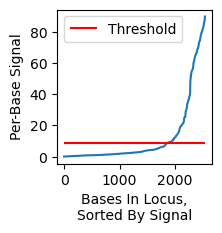

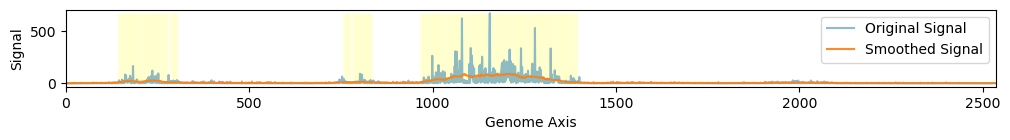

Found 3 windows that cover signal:
Window 1: 141 to 375
Window 2: 746 to 868
Window 3: 975 to 1411

Bounds containing all windows: 141 1411
Length of region containing all windows: 1270
Original region length: 2536 

Fraction of bases in any window: 0.313
Fraction of total signal captured within windows: 0.881


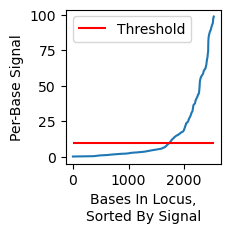

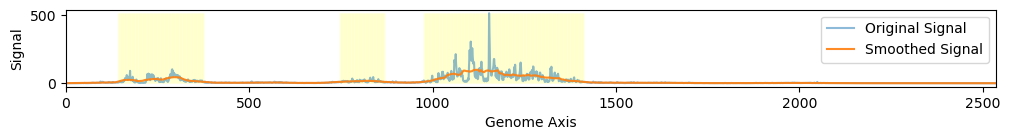

Found 1 windows that cover signal:
Window 1: 1031 to 1042

Bounds containing all windows: 1031 1042
Length of region containing all windows: 11
Original region length: 2536 

Fraction of bases in any window: 0.005
Fraction of total signal captured within windows: 0.784


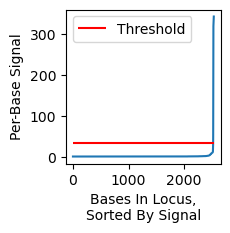

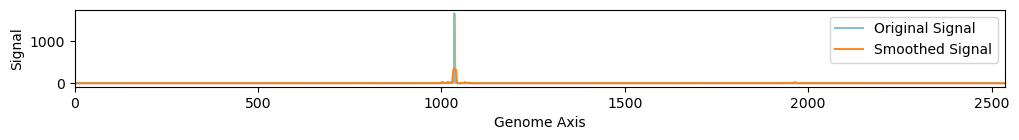

Found 1 windows that cover signal:
Window 1: 1031 to 1041

Bounds containing all windows: 1031 1041
Length of region containing all windows: 10
Original region length: 2536 

Fraction of bases in any window: 0.004
Fraction of total signal captured within windows: 0.634


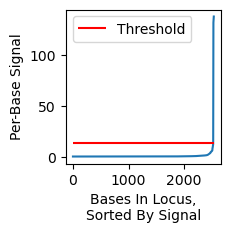

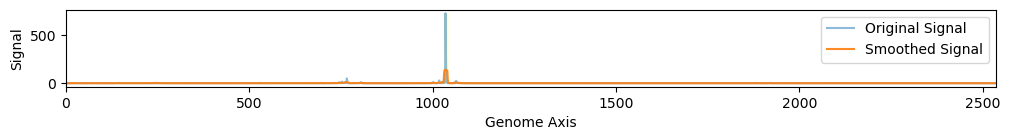

In [355]:
from collections import defaultdict

all_bounds_windows = defaultdict(lambda : dict())

all_bounds_windows["dnase"]["obs_data"] = calc_bounds(dnase_data["obs_data"])
all_bounds_windows["dnase"]["preds"] = calc_bounds(dnase_data["preds"])

all_bounds_windows["procap"]["obs_data"] = calc_bounds(procap_data["obs_data"][1], conv_width = 5)
all_bounds_windows["procap"]["preds"] = calc_bounds(procap_data["preds"][1], conv_width = 5)

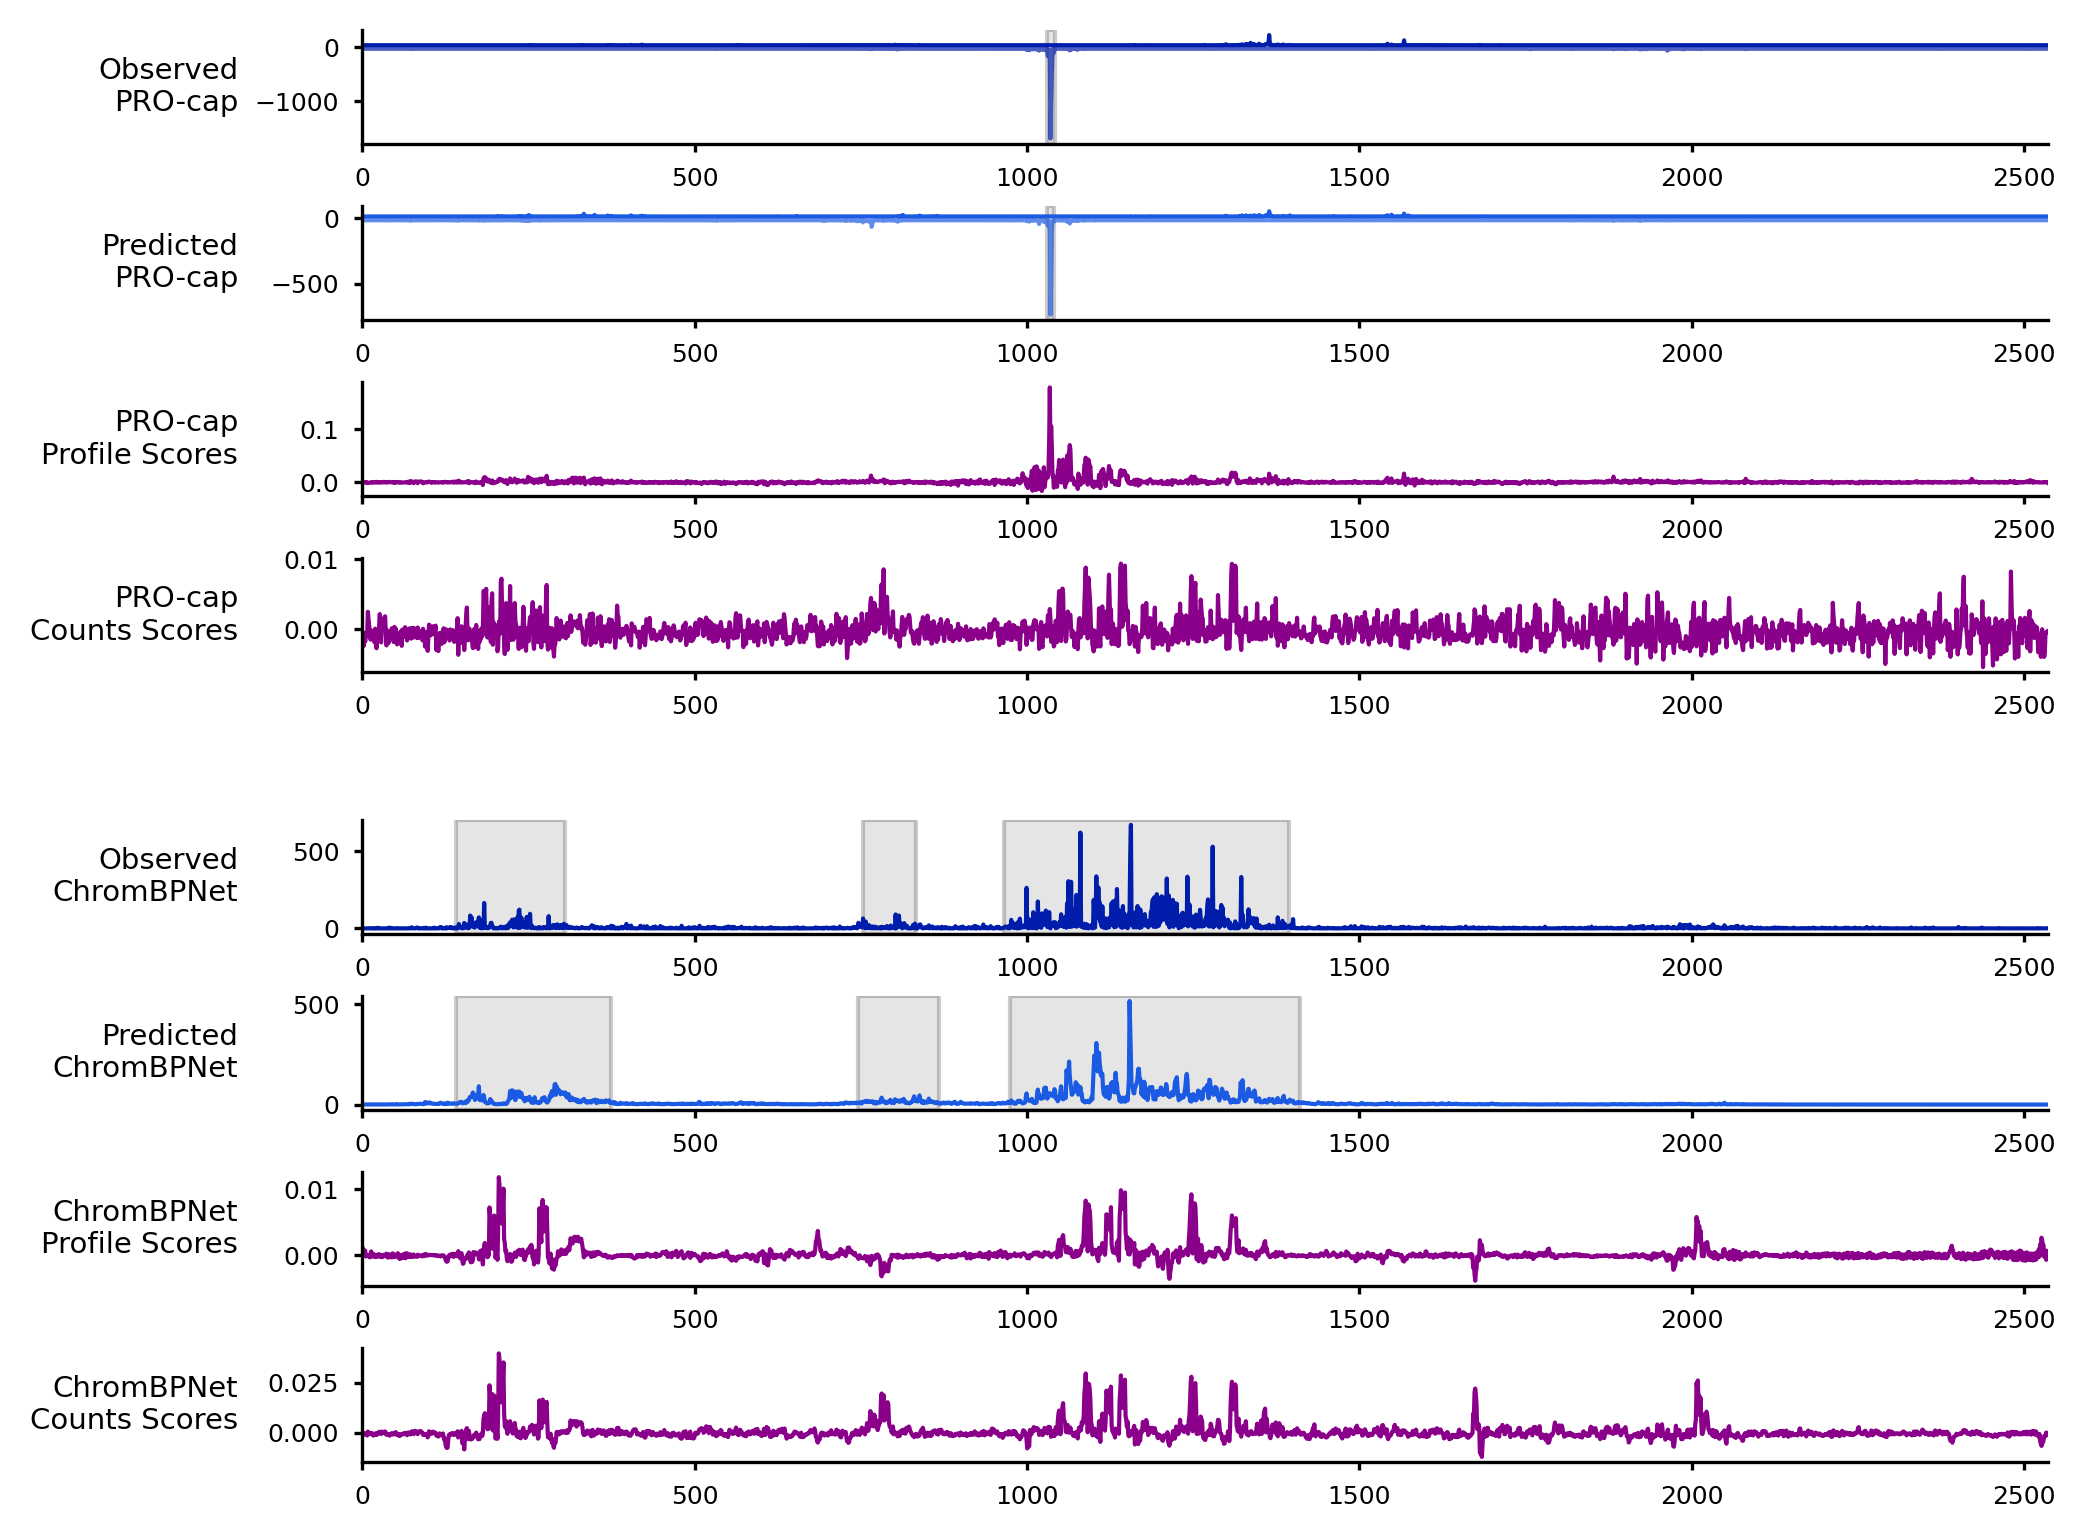

In [261]:
def highlight_window(start_pos, end_pos, ax, locus_len, height):
    rect = patches.Rectangle((start_pos, ax.get_ylim()[0]),
                             end_pos - start_pos, ax.get_ylim()[1] - ax.get_ylim()[0],
                             linewidth=1, edgecolor='k', facecolor='gray', alpha=0.2)
    ax.add_patch(rect)

    
def plot_bounds_windows(all_bounds_windows, axes, locus_len):
    axes_to_data_types = {0:["procap","obs_data"],1:["procap","preds"],
                          5:["dnase","obs_data"],6:["dnase","preds"]}
    
    for ax_i, (dnase_or_procap, data_type) in axes_to_data_types.items():
        bounds_windows = all_bounds_windows[dnase_or_procap][data_type]
        
        for bounds_window in bounds_windows:
            highlight_window(bounds_window[0], bounds_window[1], axes[ax_i],
                             locus_len, 5)


fig = plt.figure(figsize=(7.25, 6.2), dpi=300)
gs = fig.add_gridspec(9, height_ratios = [10] * 4 + [2] + [10] * 4, hspace=0.6)
axes = gs.subplots()

locus_len = max(onehot_seq.shape)

plot_tracks_for_expt(procap_data, onehot_seq, axes[:4], "PRO-cap")
plot_tracks_for_expt(dnase_data, onehot_seq, axes[5:], "ChromBPNet")
    
# aesthetics
for ax_i, ax in enumerate(axes):
    ax.tick_params(length=2, labelsize=6)
    ax.spines[["top", "right"]].set_visible(False)
    
erase_axis(axes[4])
    
fig.align_ylabels()


plot_bounds_windows(all_bounds_windows, axes, locus_len)

plt.show()

In [274]:
# is this maximally efficient? no. but we don't need mega-high throughput

def do_windows_overlap(window1, window2):
    assert window1[0] <= window2[0], (window1, window2)
    return window1[1] >= window2[0] and window1[0] < window2[1]

def do_any_windows_overlap(windows):
    for i in range(1, len(windows)):
        if do_windows_overlap(windows[i-1], windows[i]):
            return True
    return False

def merge_two_windows(window1, window2):
    return min(window1[0], window2[0]), max(window1[1], window2[1])

def bedtools_merge_bounds_windows(lists_of_bounds_windows):
    # I tested with an example somewhat decently
    all_windows_unmerged = []
    for bounds_windows in lists_of_bounds_windows:
        all_windows_unmerged.extend(bounds_windows)
        
    windows = sorted(all_windows_unmerged)
    
    # iteratively merge until no windows overlap
    while True:
        if not do_any_windows_overlap(windows):
            break
            
        new_windows = []
        skip_next = False
        for i in range(1, len(windows)):
            if do_windows_overlap(windows[i-1], windows[i]):
                new_windows.append(merge_two_windows(windows[i-1], windows[i]))
                skip_next = True
            else:
                if not skip_next:
                    new_windows.append(windows[i-1])
                skip_next = False
        
        # fix oboe issue
        if not do_windows_overlap(windows[-2], windows[-1]):
            new_windows.append(windows[-1])
        
        windows = sorted(list(set(new_windows)))
        
    return windows

In [275]:
dnase_bounds_windows = bedtools_merge_bounds_windows([all_bounds_windows["dnase"]["obs_data"],
                                                      all_bounds_windows["dnase"]["preds"]])

procap_bounds_windows = bedtools_merge_bounds_windows([all_bounds_windows["procap"]["obs_data"],
                                                       all_bounds_windows["procap"]["preds"]])

In [409]:
def pad_windows(windows, pad_by=50):
    padded_windows = []
    for window in windows:
        padded_window = (max(0, window[0] - pad_by), window[1] + pad_by)
        padded_windows.append(padded_window)
    return padded_windows

dnase_bounds_windows_pad = pad_windows(dnase_bounds_windows)
procap_bounds_windows_pad = pad_windows(procap_bounds_windows, pad_by=150)

In [390]:
def highlight_window(start_pos, end_pos, ax, locus_len, height):
    rect = patches.Rectangle((start_pos, ax.get_ylim()[0]),
                             end_pos - start_pos, ax.get_ylim()[1] - ax.get_ylim()[0],
                             linewidth=1, edgecolor='yellow', facecolor='yellow', alpha=0.1)
    ax.add_patch(rect)

def calc_bounds_scores(scores, onehot_seq = None, conv_width = 5, frac_of_max_thresh = 0.05,
                       min_dist_between_bounds = 10, min_window_width = 3):
    scores = np.abs(scores)
    
    locus_len = len(scores)
    conv_data = convolve(scores, conv_width = conv_width)
    
    scores_norm = conv_data / np.sum(conv_data)
    num_bases_to_keep = np.where(np.cumsum(np.sort(scores_norm)[::-1]) > 0.9)[0][0]
    num_bases_to_keep = min(num_bases_to_keep, locus_len // 2)  # at most liberal, use median as thresh
    indexes_above_thresh = np.sort(np.argsort(conv_data)[::-1][:num_bases_to_keep])
    bases_above_thresh = [i in indexes_above_thresh for i in range(locus_len)]
    
    assert len(indexes_above_thresh > 0)

    # figure out what mini-regions of contiguous bases do a good job
    # of covering all the bases above threshold
    
    bounds_windows = convert_bases_above_thresh_to_bounds(indexes_above_thresh, locus_len,
                                        min_dist_between_bounds = min_dist_between_bounds)
    
    # remove 1-base-wide windows
    bounds_windows = [window for window in bounds_windows if window[1] - window[0] >= min_window_width]
    
    
    # then report results
    
    num_bounds_windows = len(bounds_windows)
    print("Found " + str(num_bounds_windows) + " windows that cover signal:")
    for window_i, (bounds_window_start, bounds_window_end) in enumerate(bounds_windows):
        print("Window " + str(window_i + 1) + ":", bounds_window_start, "to", bounds_window_end)
    print()
    
    overall_bounds = min(indexes_above_thresh), max(indexes_above_thresh)
    
    print("Bounds containing all windows:", overall_bounds[0], overall_bounds[1])
    print("Length of region containing all windows:", overall_bounds[1] - overall_bounds[0])
    print("Original region length:", locus_len, "\n")
    
    # report some stats
    
    frac_bases_above_thresh = num_bases_to_keep / locus_len
    print("Fraction of bases in any window: %0.3f" % frac_bases_above_thresh)
    
    frac_signal_at_bases_above_thresh = np.sum(conv_data[bases_above_thresh]) / np.sum(conv_data)
    print("Fraction of all score magnitude captured within windows: %0.3f" % frac_signal_at_bases_above_thresh)
    
    plt.figure(figsize=(2,1.7))
    plt.plot(np.arange(locus_len), np.sort(conv_data))
    plt.vlines(locus_len - num_bases_to_keep, 0, plt.gca().get_ylim()[1], color="r", label="Threshold")
    plt.ylabel("Scores")
    plt.xlabel("Bases In Locus,\nSorted By Signal")
    plt.legend()
    plt.show()
    
    
    if onehot_seq is not None:
        plt.figure(figsize=(12,1))
        plot_motif_on_ax(scores * onehot_seq, plt.gca())
        
        for window in bounds_windows:
            highlight_window(window[0], window[1], plt.gca(), locus_len, np.max(scores),)
        
        plt.xlim(0, locus_len)
        
        plt.show()
    
        plt.figure(figsize=(12,1))
        
    else:
        plt.plot(range(locus_len), scores, alpha=0.9, label="Original Scores")
    
    plt.plot(range(locus_len), conv_data, alpha=0.9, label="Smoothed Scores")
    plt.xlim(0, locus_len)
    
    for window in bounds_windows:
        highlight_window(window[0], window[1], plt.gca(), locus_len, np.max(conv_data))
    plt.gca().spines[["top", "right"]].set_visible(False)
        
    plt.show()
    
    return overall_bounds, bounds_windows

Found 3 windows that cover signal:
Window 1: 33 to 39
Window 2: 56 to 132
Window 3: 147 to 244

Bounds containing all windows: 33 244
Length of region containing all windows: 211
Original region length: 334 

Fraction of bases in any window: 0.500
Fraction of all score magnitude captured within windows: 0.892


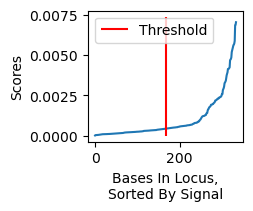

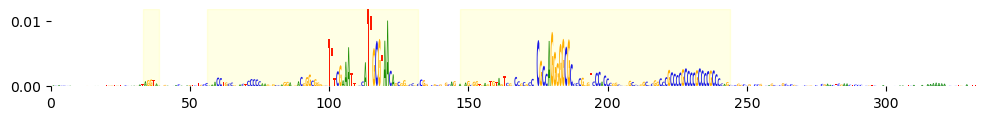

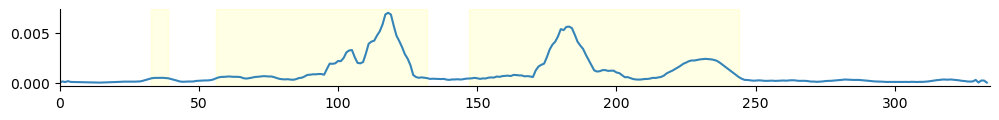

Found 3 windows that cover signal:
Window 1: 1 to 102
Window 2: 113 to 122
Window 3: 163 to 176

Bounds containing all windows: 1 219
Length of region containing all windows: 218
Original region length: 222 

Fraction of bases in any window: 0.500
Fraction of all score magnitude captured within windows: 0.788


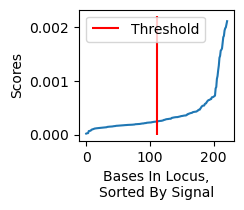

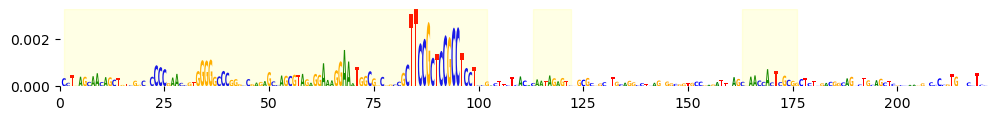

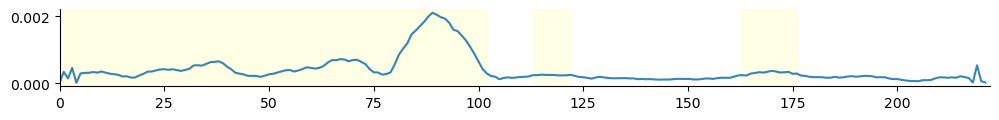

Found 3 windows that cover signal:
Window 1: 128 to 152
Window 2: 163 to 414
Window 3: 435 to 448

Bounds containing all windows: 0 448
Length of region containing all windows: 448
Original region length: 546 

Fraction of bases in any window: 0.500
Fraction of all score magnitude captured within windows: 0.899


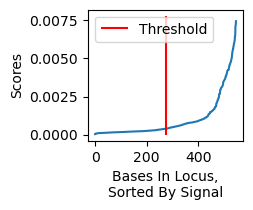

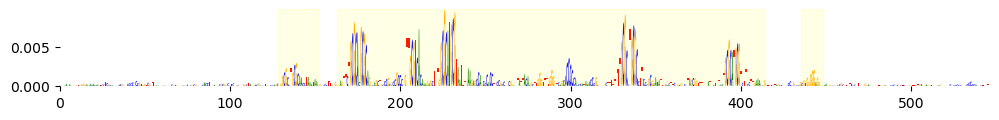

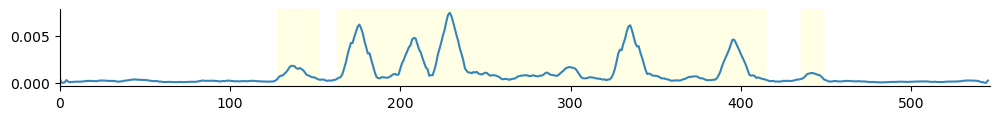

Found 4 windows that cover signal:
Window 1: 30 to 42
Window 2: 56 to 152
Window 3: 162 to 202
Window 4: 219 to 243

Bounds containing all windows: 30 333
Length of region containing all windows: 303
Original region length: 334 

Fraction of bases in any window: 0.500
Fraction of all score magnitude captured within windows: 0.857


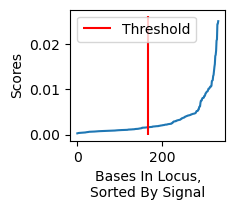

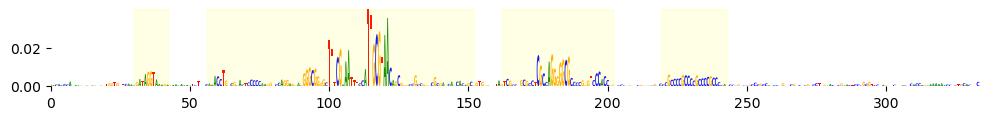

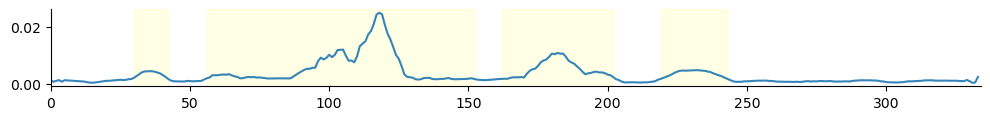

Found 4 windows that cover signal:
Window 1: 20 to 42
Window 2: 57 to 103
Window 3: 121 to 156
Window 4: 190 to 195

Bounds containing all windows: 4 217
Length of region containing all windows: 213
Original region length: 222 

Fraction of bases in any window: 0.500
Fraction of all score magnitude captured within windows: 0.810


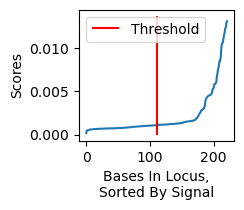

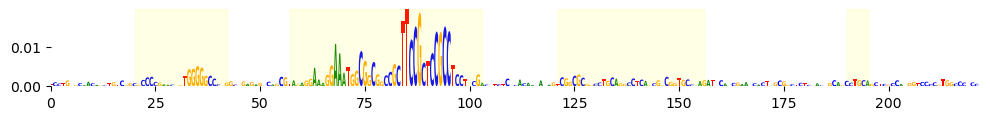

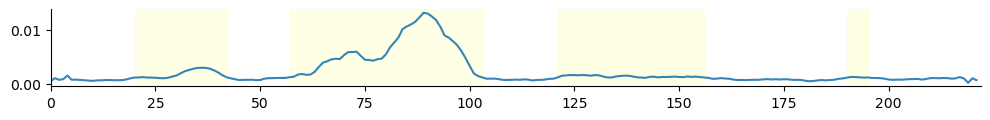

Found 7 windows that cover signal:
Window 1: 73 to 93
Window 2: 128 to 146
Window 3: 163 to 269
Window 4: 285 to 353
Window 5: 369 to 415
Window 6: 433 to 469
Window 7: 507 to 513

Bounds containing all windows: 73 533
Length of region containing all windows: 460
Original region length: 546 

Fraction of bases in any window: 0.500
Fraction of all score magnitude captured within windows: 0.835


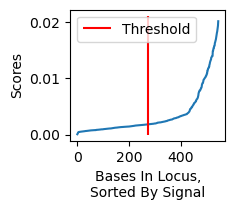

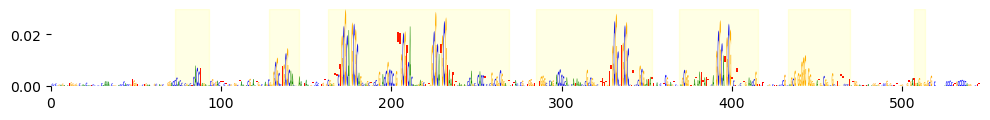

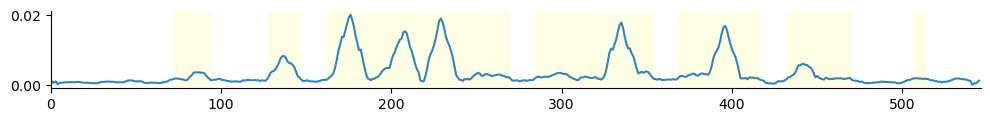

In [391]:
def adjust_bounds_by_original_window(bounds_windows, adjust_by):
    adjusted_windows = []
    for window in bounds_windows:
        adjusted_windows.append((window[0] + adjust_by, window[1] + adjust_by))
    return adjusted_windows

def get_all_score_bounds_windows(data_bounds_windows, scores, onehot_seq, frac_of_max_thresh = 0.05):
    score_bounds_windows = []
    for window in data_bounds_windows:
        scores_within_window = scores[window[0] : window[1]]
    
        _, score_bounds_within_window = calc_bounds_scores(scores_within_window,
                                                           onehot_seq[:, window[0] : window[1]],
                                                           frac_of_max_thresh = frac_of_max_thresh)
        
        score_bounds_within_window = adjust_bounds_by_original_window(score_bounds_within_window,
                                                                      window[0])
        score_bounds_windows.extend(score_bounds_within_window)

    return score_bounds_windows

    
all_bounds_windows["dnase"]["profile_scores"] = get_all_score_bounds_windows(dnase_bounds_windows_pad,
                                                                             dnase_data["scores"]["profile"],
                                                                             onehot_seq)
all_bounds_windows["dnase"]["counts_scores"] = get_all_score_bounds_windows(dnase_bounds_windows_pad,
                                                                            dnase_data["scores"]["counts"],
                                                                            onehot_seq)

Found 1 windows that cover signal:
Window 1: 108 to 271

Bounds containing all windows: 108 271
Length of region containing all windows: 163
Original region length: 311 

Fraction of bases in any window: 0.498
Fraction of all score magnitude captured within windows: 0.874


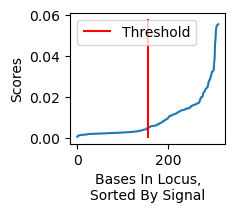

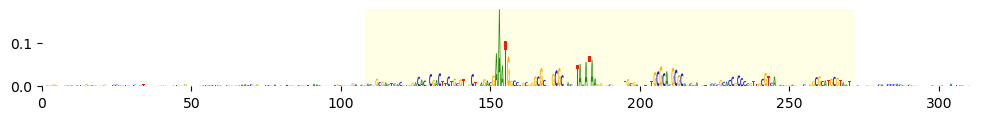

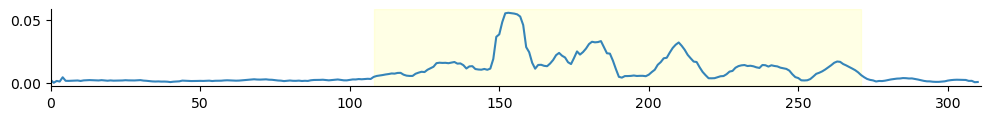

In [392]:
all_bounds_windows["procap"]["profile_scores"] = get_all_score_bounds_windows(procap_bounds_windows_pad,
                                                                              procap_data["scores"]["profile"],
                                                                              onehot_seq,
                                                                              frac_of_max_thresh = 0.1)

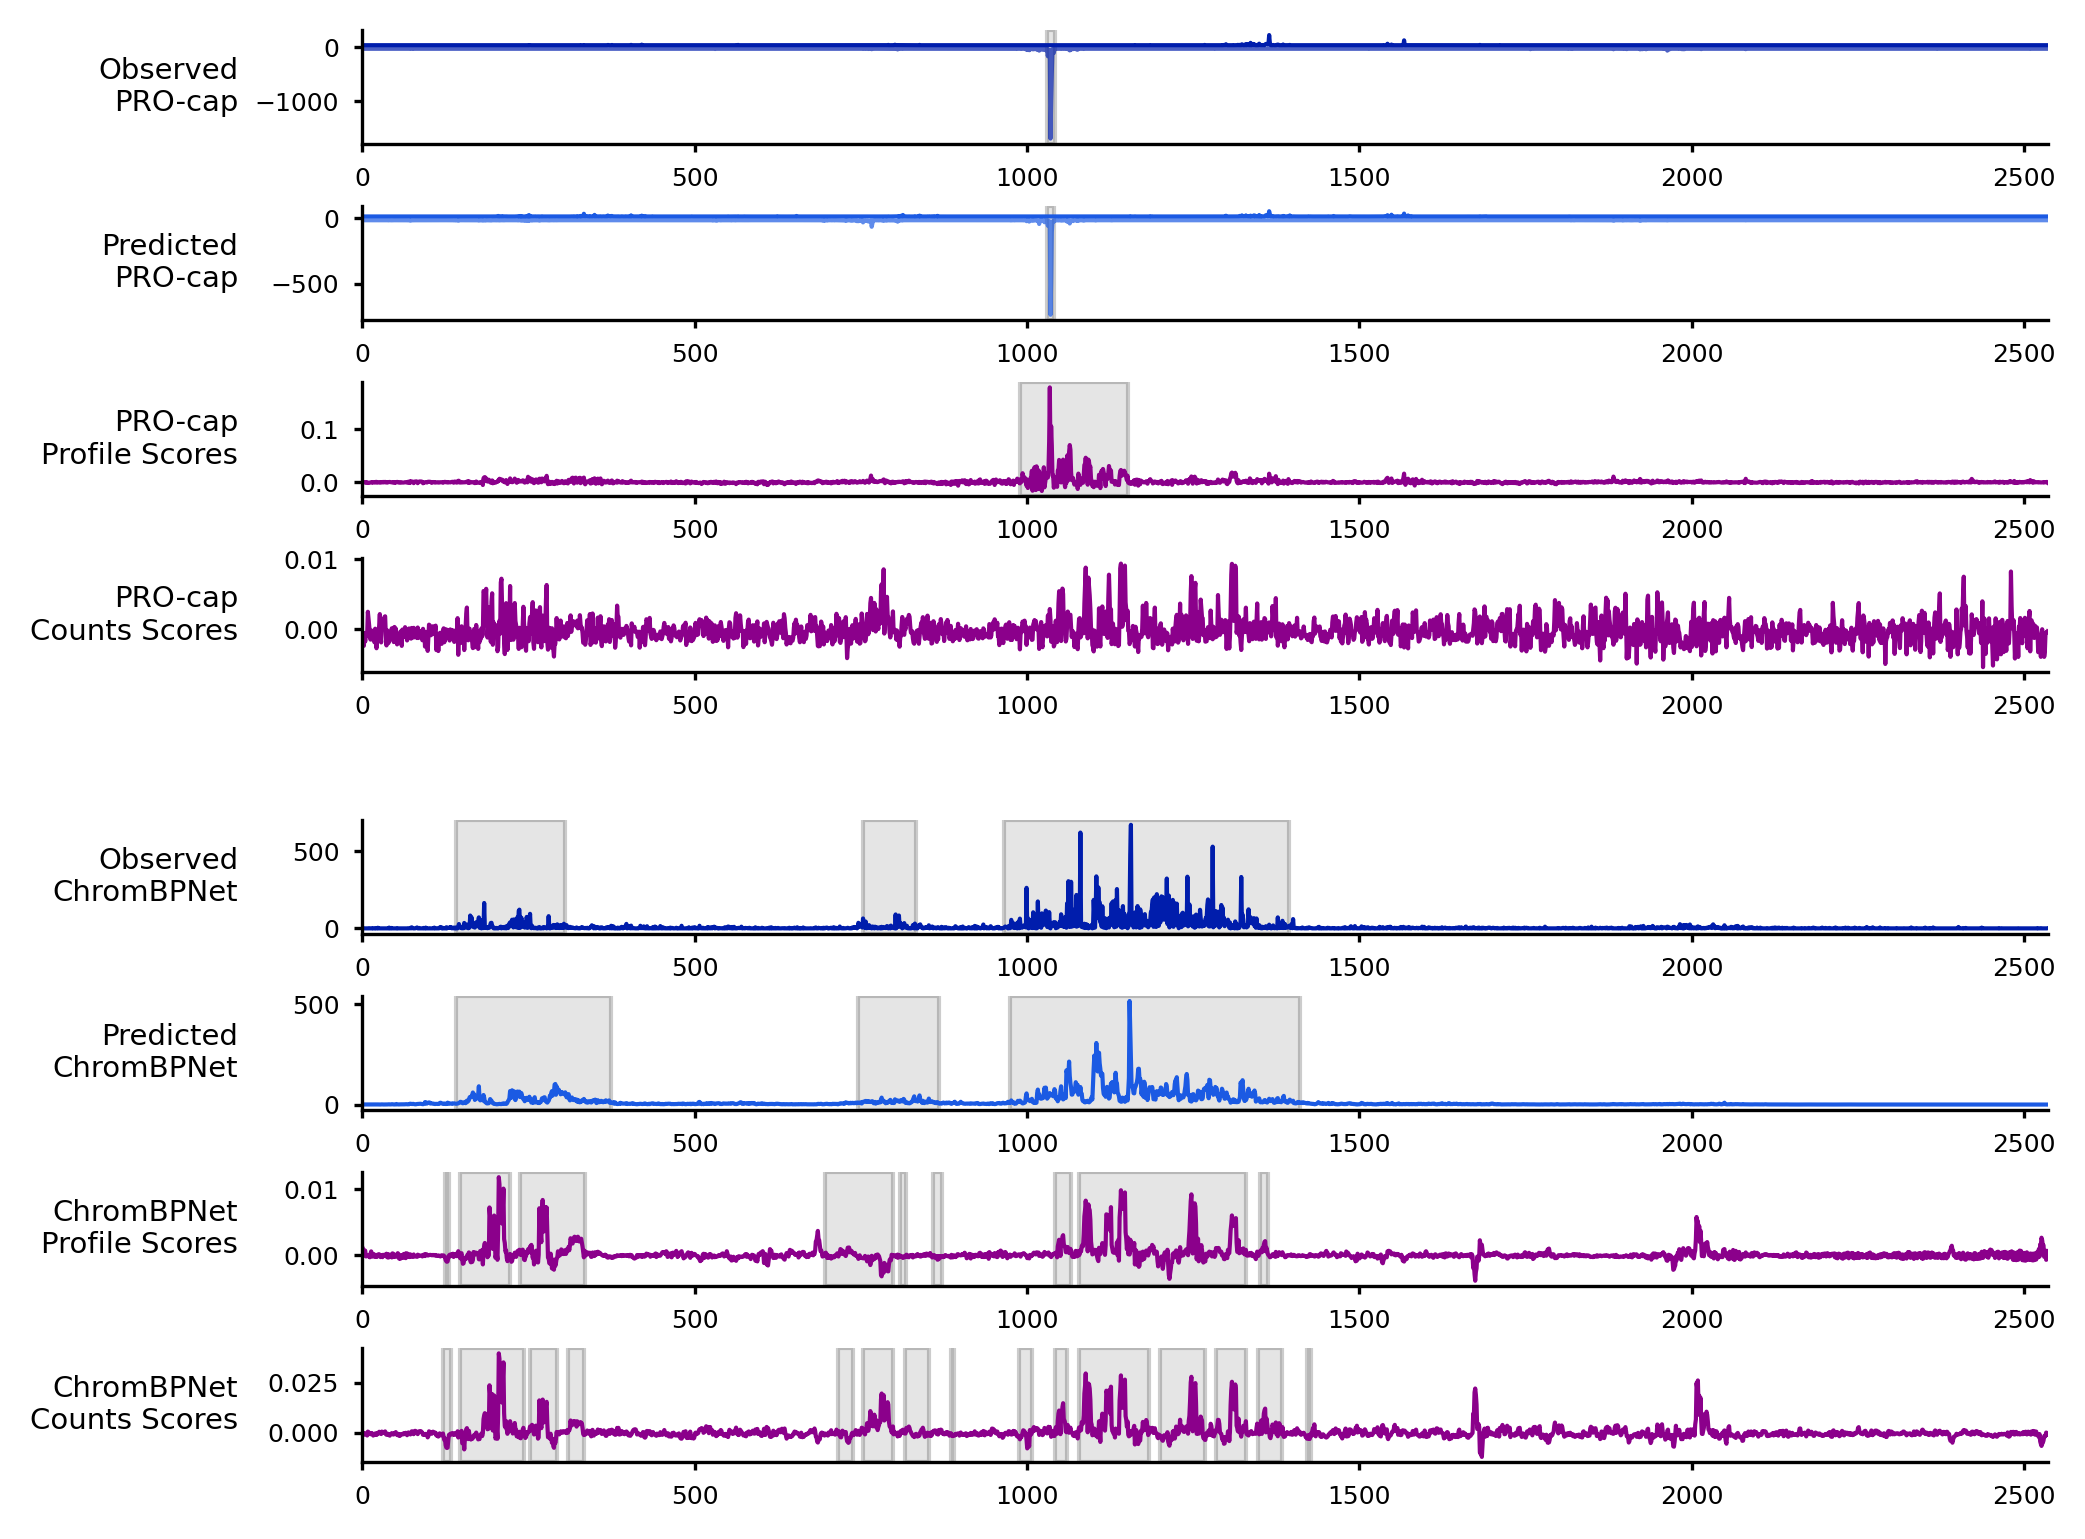

In [393]:
def highlight_window(start_pos, end_pos, ax, locus_len, height):
    rect = patches.Rectangle((start_pos, ax.get_ylim()[0]),
                             end_pos - start_pos, ax.get_ylim()[1] - ax.get_ylim()[0],
                             linewidth=1, edgecolor='k', facecolor='gray', alpha=0.2)
    ax.add_patch(rect)

    
def plot_bounds_windows(all_bounds_windows, axes, locus_len):
    axes_to_data_types = {0:["procap","obs_data"],1:["procap","preds"],
                          2:["procap", "profile_scores"],
                          5:["dnase","obs_data"],6:["dnase","preds"],
                          7:["dnase", "profile_scores"],8:["dnase", "counts_scores"]}
    
    for ax_i, (dnase_or_procap, data_type) in axes_to_data_types.items():
        bounds_windows = all_bounds_windows[dnase_or_procap][data_type]
        
        for bounds_window in bounds_windows:
            highlight_window(bounds_window[0], bounds_window[1], axes[ax_i],
                             locus_len, 5)


fig = plt.figure(figsize=(7.25, 6.2), dpi=300)
gs = fig.add_gridspec(9, height_ratios = [10] * 4 + [2] + [10] * 4, hspace=0.6)
axes = gs.subplots()

locus_len = max(onehot_seq.shape)

plot_tracks_for_expt(procap_data, onehot_seq, axes[:4], "PRO-cap")
plot_tracks_for_expt(dnase_data, onehot_seq, axes[5:], "ChromBPNet")
    
# aesthetics
for ax_i, ax in enumerate(axes):
    ax.tick_params(length=2, labelsize=6)
    ax.spines[["top", "right"]].set_visible(False)
    
erase_axis(axes[4])
    
fig.align_ylabels()


plot_bounds_windows(all_bounds_windows, axes, locus_len)

plt.show()

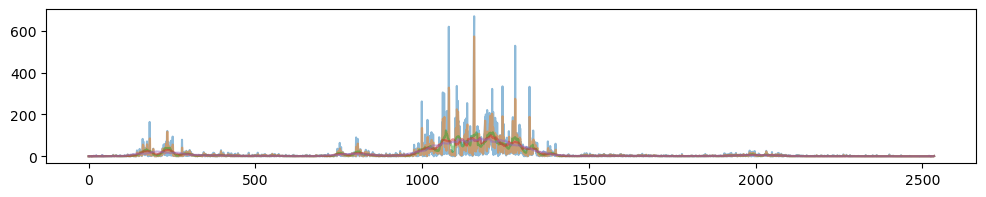

In [240]:
plt.figure(figsize=(12,2))
plt.plot(range(len(dnase_data["obs_data"])), dnase_data["obs_data"], alpha=0.5)
plt.plot(range(len(dnase_data["obs_data"])), convolve(dnase_data["obs_data"], conv_width = 1), alpha=0.5)
#plt.plot(range(12382), convolve(dnase_data["obs_data"], conv_width = 3), alpha=0.5)
plt.plot(range(len(dnase_data["obs_data"])), convolve(dnase_data["obs_data"], conv_width = 10), alpha=0.5)
plt.plot(range(len(dnase_data["obs_data"])), convolve(dnase_data["obs_data"], conv_width = 20), alpha=0.5)
plt.plot(range(len(dnase_data["obs_data"])), convolve(dnase_data["obs_data"], conv_width = 50), alpha=0.5)
plt.show()

In [397]:
chrom, start, end = promoter_coords[308][:3]

onehot_seq = load_sequence_at_locus(chrom, start, end, genome_path)

dnase_data = load_all_data_for_locus(chrom, start, end, all_bw_paths["dnase"])
procap_data = load_all_data_for_locus(chrom, start, end, all_bw_paths["procap"])

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


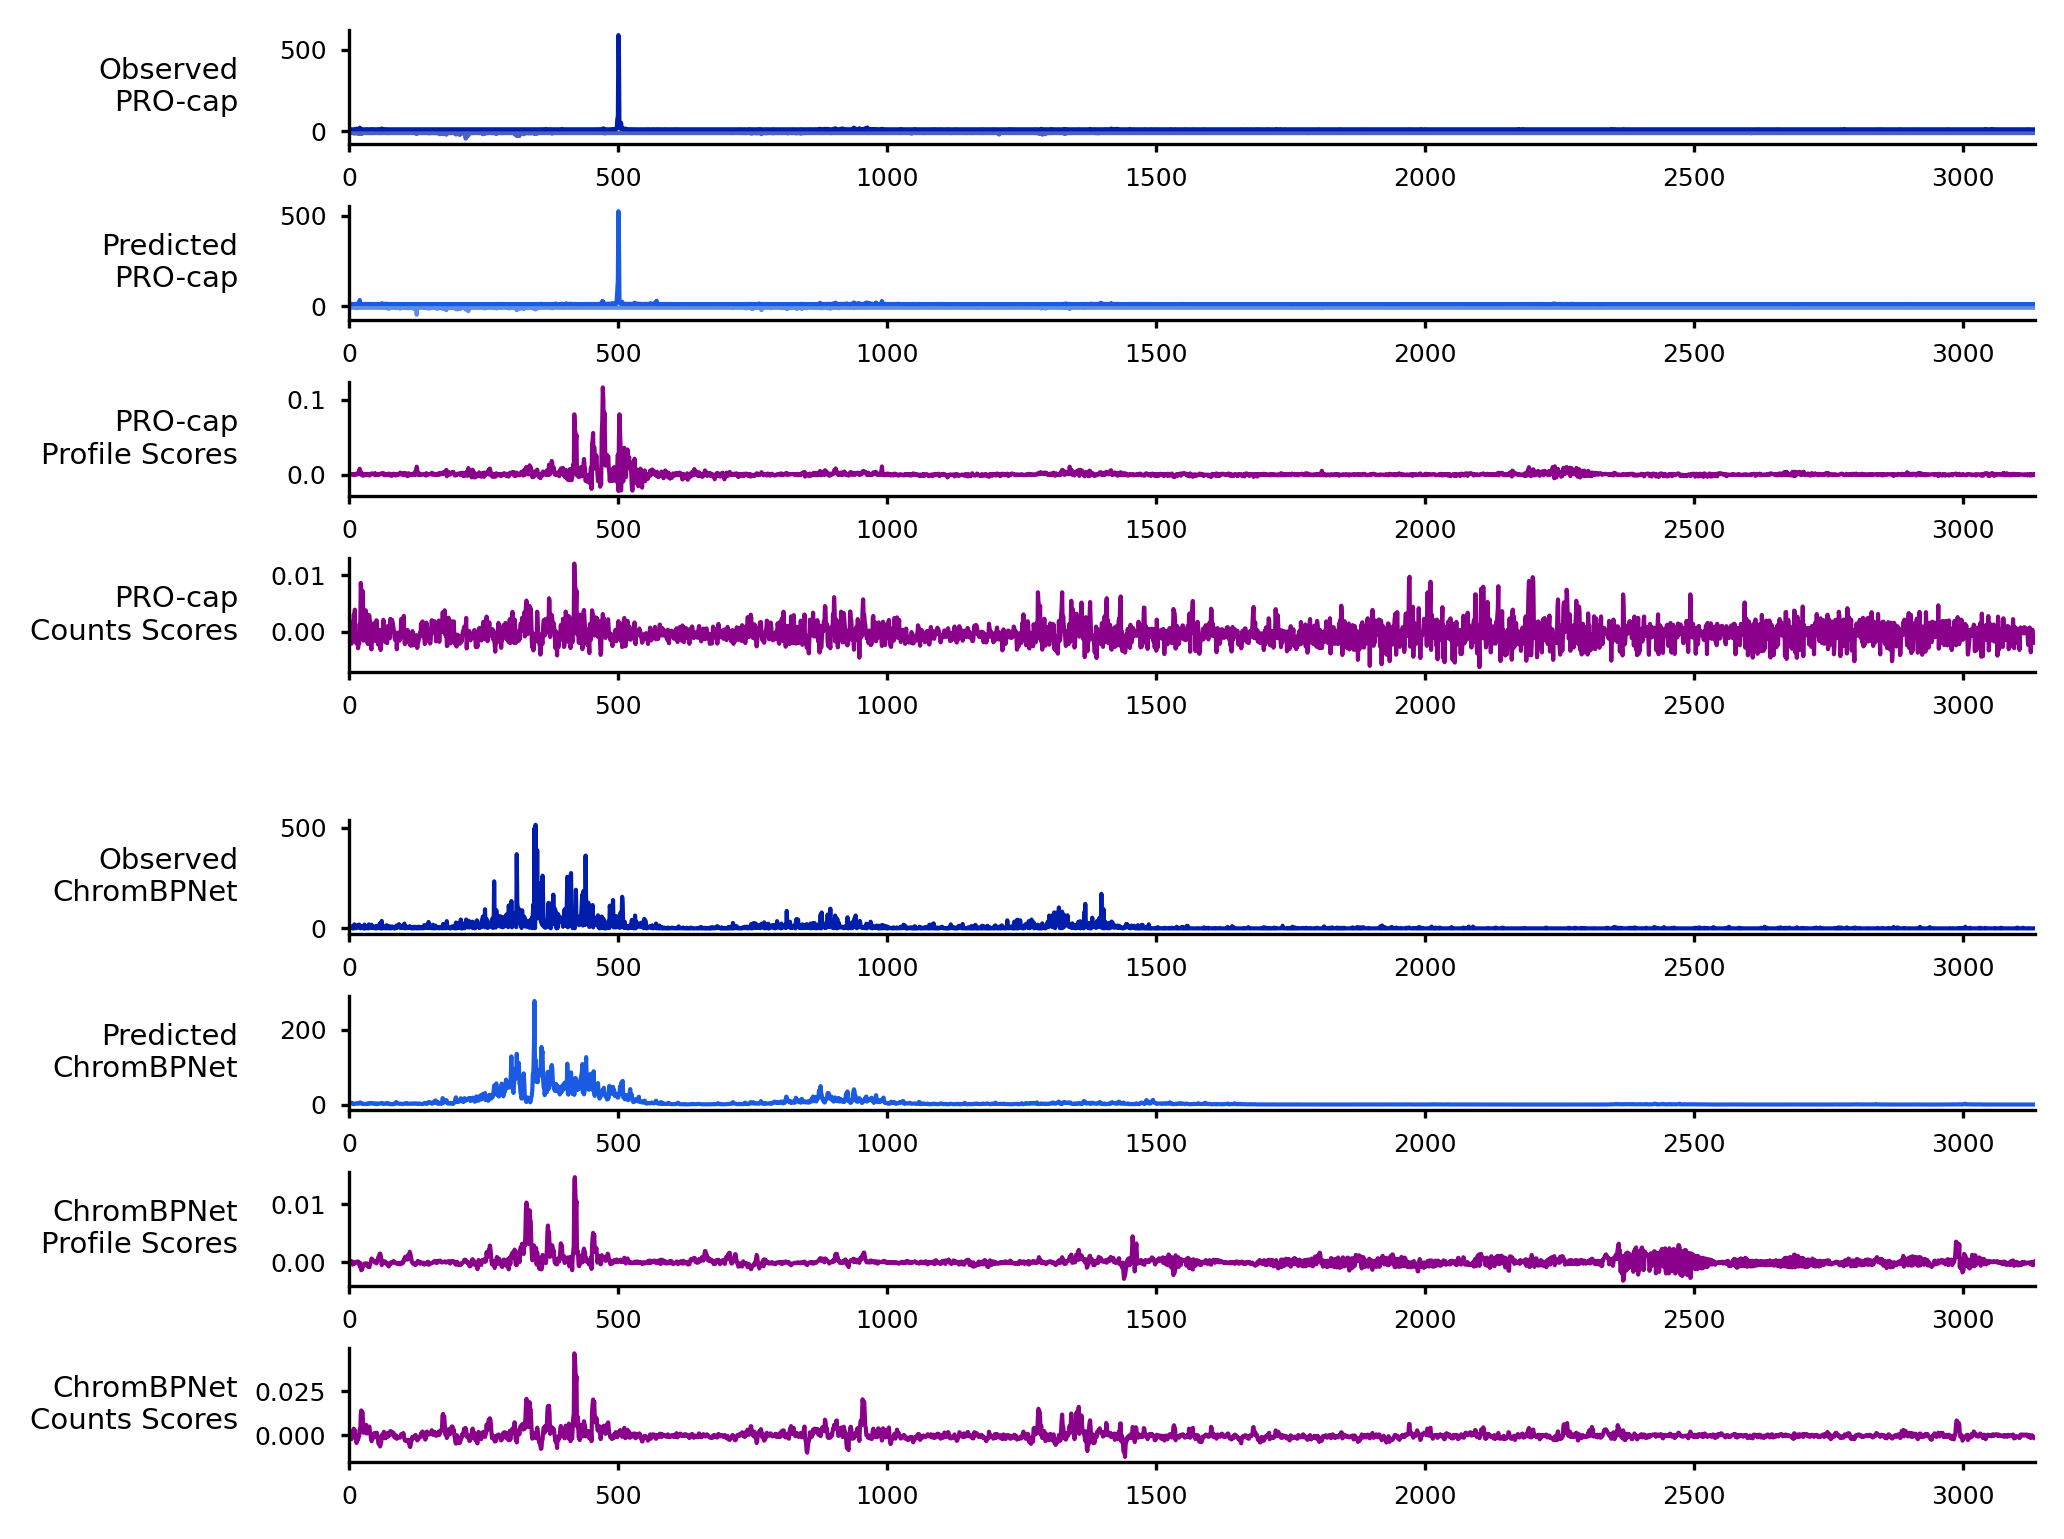

In [398]:
fig = plt.figure(figsize=(7.25, 6.2), dpi=300)
gs = fig.add_gridspec(9, height_ratios = [10] * 4 + [2] + [10] * 4, hspace=0.6)
axes = gs.subplots()


plot_tracks_for_expt(procap_data, onehot_seq, axes[:4], "PRO-cap")
plot_tracks_for_expt(dnase_data, onehot_seq, axes[5:], "ChromBPNet")
    
for ax_i, ax in enumerate(axes):
    ax.tick_params(length=2, labelsize=6)
    ax.spines[["top", "right"]].set_visible(False)
    
erase_axis(axes[4])
    
fig.align_ylabels()

plt.show()

Found 4 windows that cover signal:
Window 1: 1 to 22
Window 2: 194 to 565
Window 3: 769 to 966
Window 4: 1239 to 1427

Bounds containing all windows: 1 1427
Length of region containing all windows: 1426
Original region length: 3134 

Fraction of bases in any window: 0.245
Fraction of total signal captured within windows: 0.855


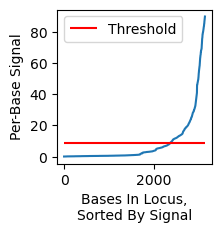

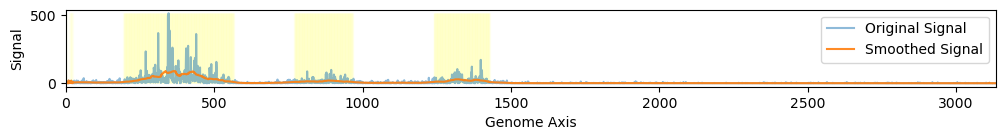

Found 2 windows that cover signal:
Window 1: 190 to 549
Window 2: 808 to 996

Bounds containing all windows: 190 996
Length of region containing all windows: 806
Original region length: 3134 

Fraction of bases in any window: 0.175
Fraction of total signal captured within windows: 0.825


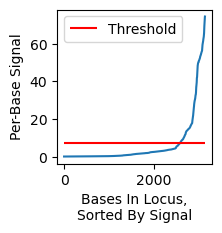

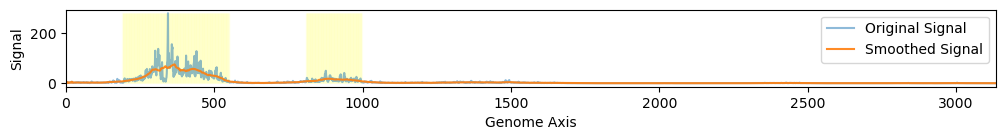

Found 1 windows that cover signal:
Window 1: 495 to 506

Bounds containing all windows: 495 506
Length of region containing all windows: 11
Original region length: 3134 

Fraction of bases in any window: 0.004
Fraction of total signal captured within windows: 0.778


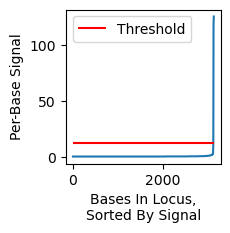

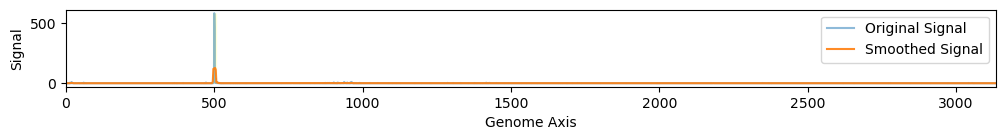

Found 1 windows that cover signal:
Window 1: 494 to 506

Bounds containing all windows: 494 506
Length of region containing all windows: 12
Original region length: 3134 

Fraction of bases in any window: 0.004
Fraction of total signal captured within windows: 0.676


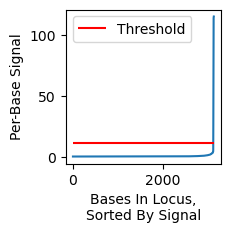

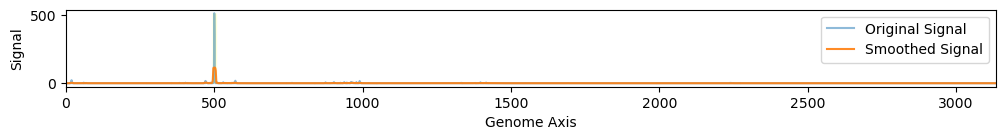

In [401]:
from collections import defaultdict

all_bounds_windows = defaultdict(lambda : dict())

all_bounds_windows["dnase"]["obs_data"] = calc_bounds(dnase_data["obs_data"])
all_bounds_windows["dnase"]["preds"] = calc_bounds(dnase_data["preds"])

all_bounds_windows["procap"]["obs_data"] = calc_bounds(procap_data["obs_data"][0], conv_width = 5)
all_bounds_windows["procap"]["preds"] = calc_bounds(procap_data["preds"][0], conv_width = 5)

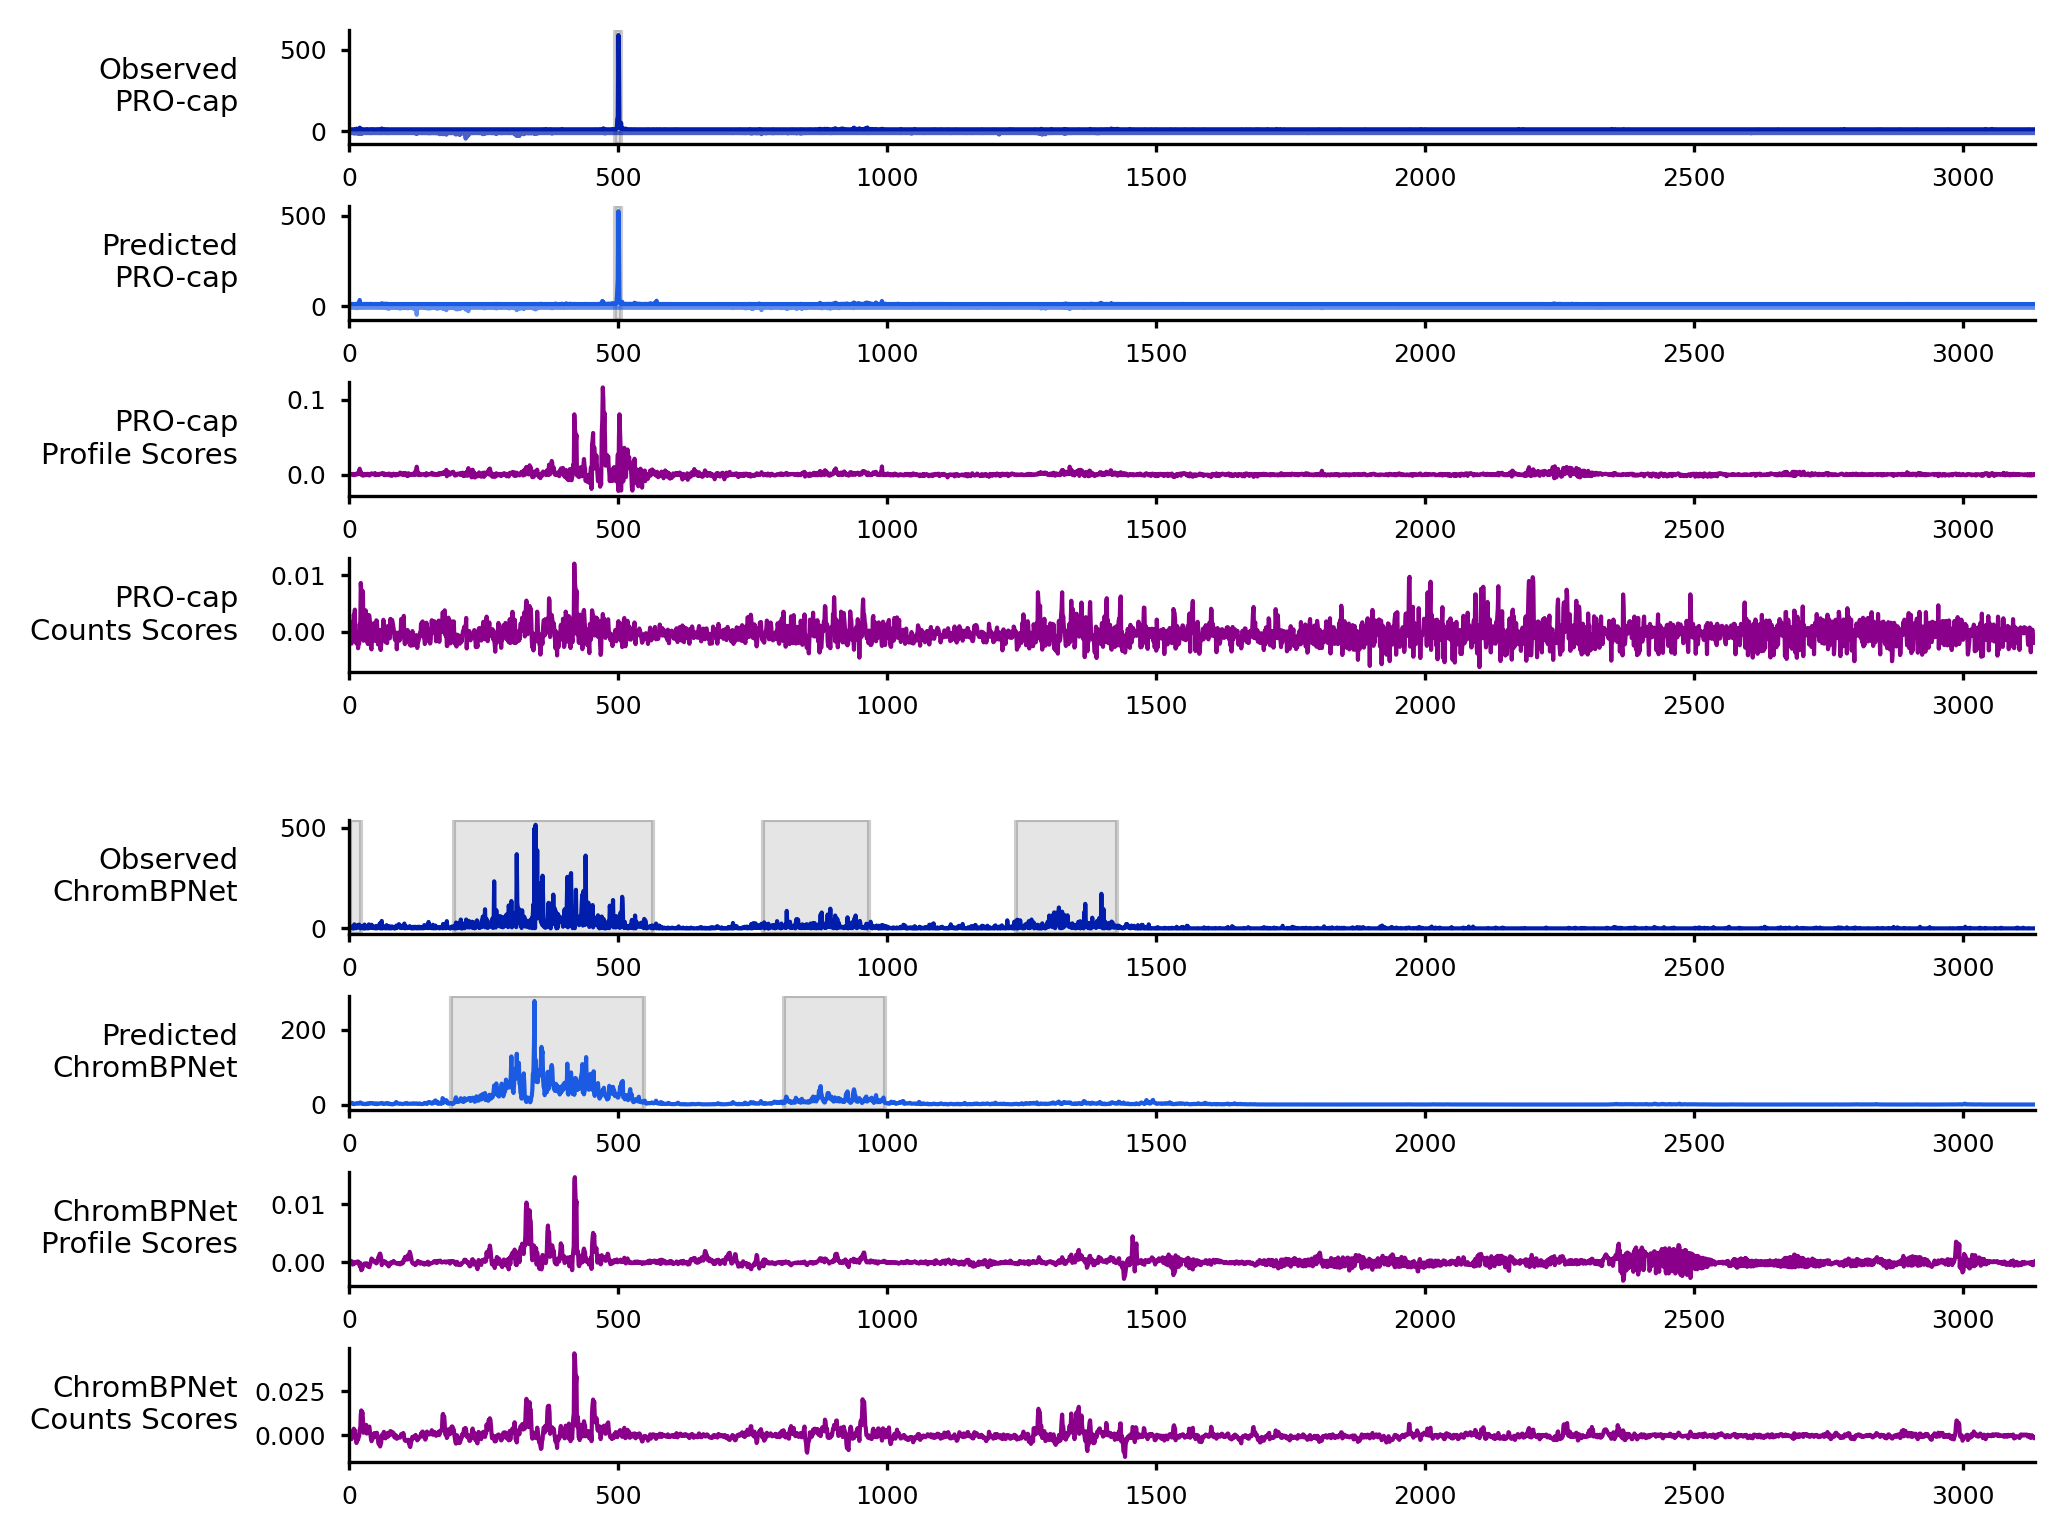

In [402]:
def highlight_window(start_pos, end_pos, ax, locus_len, height):
    rect = patches.Rectangle((start_pos, ax.get_ylim()[0]),
                             end_pos - start_pos, ax.get_ylim()[1] - ax.get_ylim()[0],
                             linewidth=1, edgecolor='k', facecolor='gray', alpha=0.2)
    ax.add_patch(rect)

    
def plot_bounds_windows(all_bounds_windows, axes, locus_len):
    axes_to_data_types = {0:["procap","obs_data"],1:["procap","preds"],
                          5:["dnase","obs_data"],6:["dnase","preds"]}
    
    for ax_i, (dnase_or_procap, data_type) in axes_to_data_types.items():
        bounds_windows = all_bounds_windows[dnase_or_procap][data_type]
        
        for bounds_window in bounds_windows:
            highlight_window(bounds_window[0], bounds_window[1], axes[ax_i],
                             locus_len, 5)


fig = plt.figure(figsize=(7.25, 6.2), dpi=300)
gs = fig.add_gridspec(9, height_ratios = [10] * 4 + [2] + [10] * 4, hspace=0.6)
axes = gs.subplots()

locus_len = max(onehot_seq.shape)

plot_tracks_for_expt(procap_data, onehot_seq, axes[:4], "PRO-cap")
plot_tracks_for_expt(dnase_data, onehot_seq, axes[5:], "ChromBPNet")
    
# aesthetics
for ax_i, ax in enumerate(axes):
    ax.tick_params(length=2, labelsize=6)
    ax.spines[["top", "right"]].set_visible(False)
    
erase_axis(axes[4])
    
fig.align_ylabels()


plot_bounds_windows(all_bounds_windows, axes, locus_len)

plt.show()

In [410]:
dnase_bounds_windows = bedtools_merge_bounds_windows([all_bounds_windows["dnase"]["obs_data"],
                                                      all_bounds_windows["dnase"]["preds"]])

procap_bounds_windows = bedtools_merge_bounds_windows([all_bounds_windows["procap"]["obs_data"],
                                                       all_bounds_windows["procap"]["preds"]])

dnase_bounds_windows_pad = pad_windows(dnase_bounds_windows)
procap_bounds_windows_pad = pad_windows(procap_bounds_windows, pad_by=150)

(0, 72)
Found 1 windows that cover signal:
Window 1: 19 to 42

Bounds containing all windows: 19 71
Length of region containing all windows: 52
Original region length: 72 

Fraction of bases in any window: 0.500
Fraction of all score magnitude captured within windows: 0.752


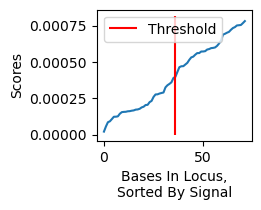

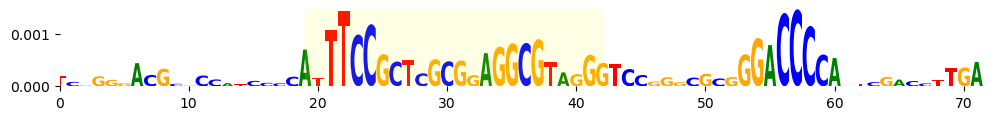

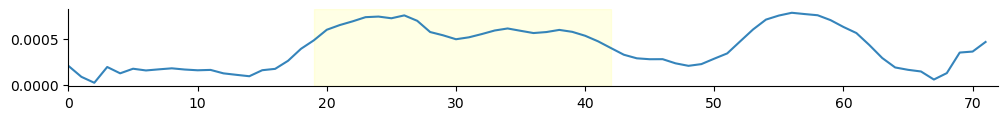

(140, 615)
Found 1 windows that cover signal:
Window 1: 85 to 346

Bounds containing all windows: 2 346
Length of region containing all windows: 344
Original region length: 475 

Fraction of bases in any window: 0.499
Fraction of all score magnitude captured within windows: 0.897


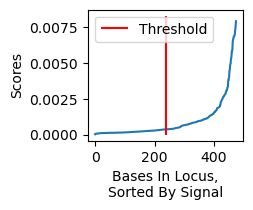

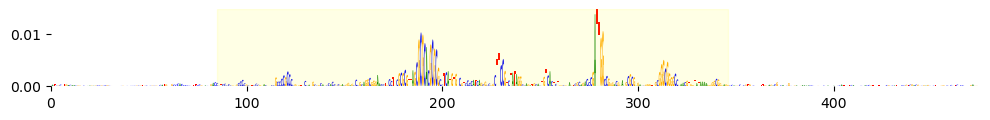

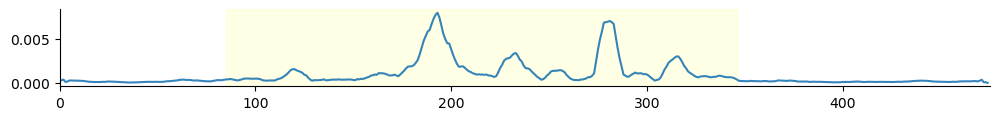

(719, 1046)
Found 5 windows that cover signal:
Window 1: 0 to 74
Window 2: 98 to 108
Window 3: 128 to 135
Window 4: 152 to 193
Window 5: 203 to 244

Bounds containing all windows: 0 244
Length of region containing all windows: 244
Original region length: 327 

Fraction of bases in any window: 0.498
Fraction of all score magnitude captured within windows: 0.787


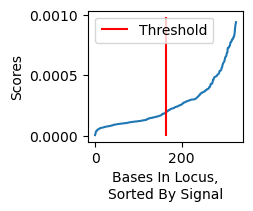

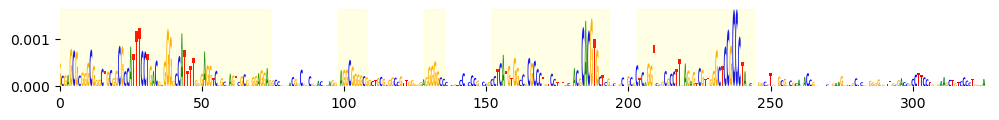

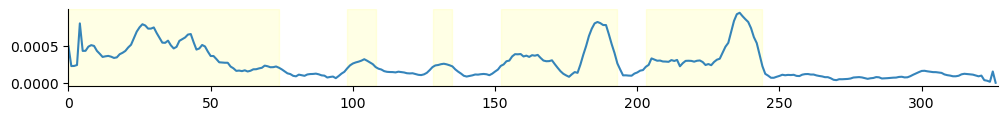

(1189, 1477)
Found 2 windows that cover signal:
Window 1: 91 to 98
Window 2: 126 to 211

Bounds containing all windows: 2 285
Length of region containing all windows: 283
Original region length: 288 

Fraction of bases in any window: 0.500
Fraction of all score magnitude captured within windows: 0.802


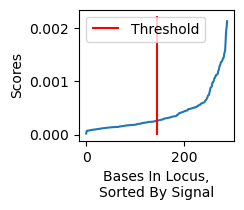

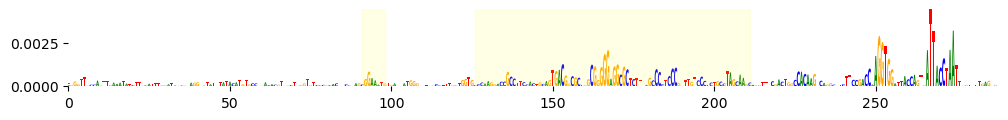

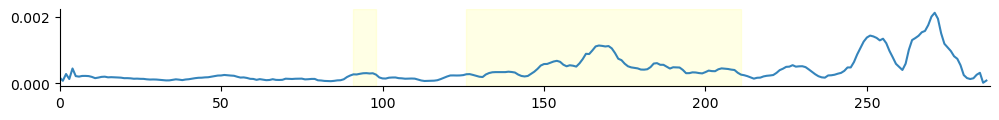

(0, 72)
Found 2 windows that cover signal:
Window 1: 11 to 40
Window 2: 53 to 61

Bounds containing all windows: 11 61
Length of region containing all windows: 50
Original region length: 72 

Fraction of bases in any window: 0.500
Fraction of all score magnitude captured within windows: 0.717


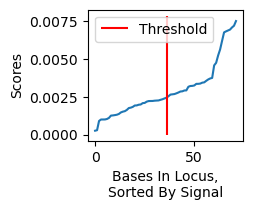

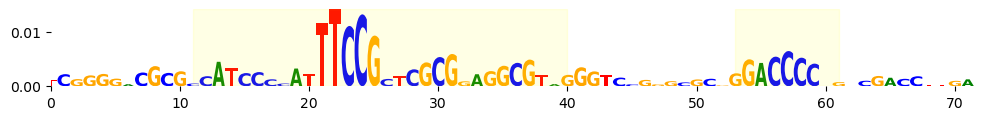

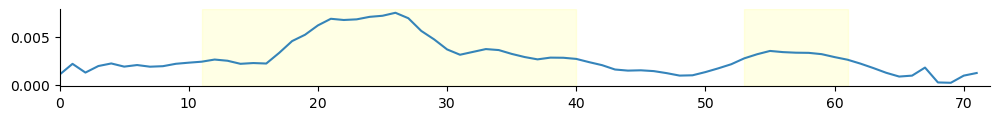

(140, 615)
Found 3 windows that cover signal:
Window 1: 29 to 99
Window 2: 114 to 127
Window 3: 163 to 345

Bounds containing all windows: 1 345
Length of region containing all windows: 344
Original region length: 475 

Fraction of bases in any window: 0.499
Fraction of all score magnitude captured within windows: 0.812


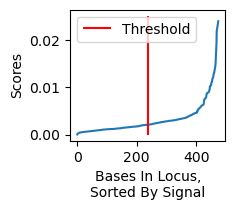

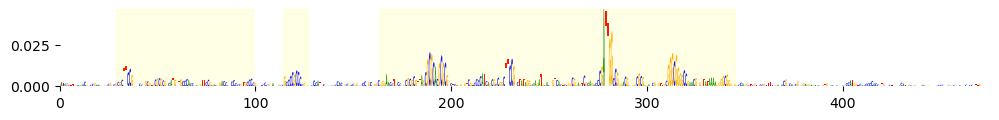

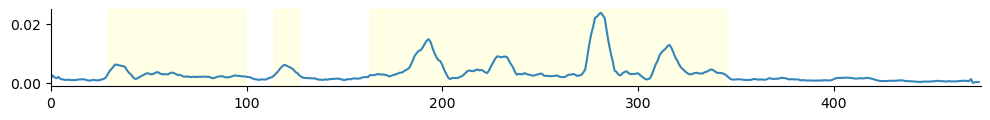

(719, 1046)
Found 4 windows that cover signal:
Window 1: 23 to 51
Window 2: 98 to 107
Window 3: 125 to 255
Window 4: 269 to 292

Bounds containing all windows: 0 325
Length of region containing all windows: 325
Original region length: 327 

Fraction of bases in any window: 0.498
Fraction of all score magnitude captured within windows: 0.754


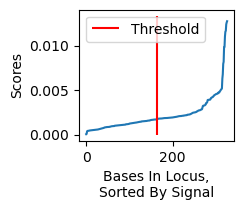

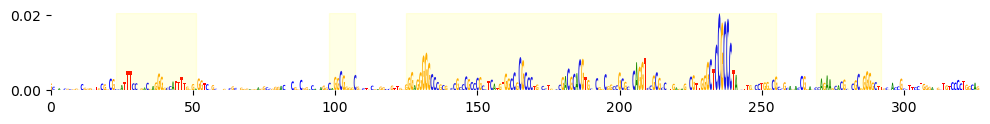

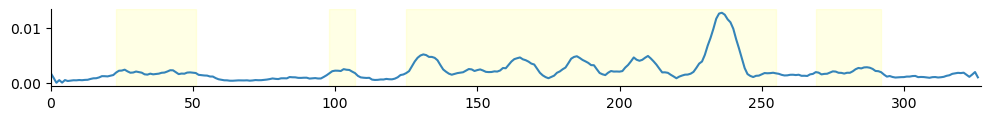

(1189, 1477)
Found 4 windows that cover signal:
Window 1: 73 to 108
Window 2: 119 to 223
Window 3: 241 to 259
Window 4: 269 to 273

Bounds containing all windows: 73 273
Length of region containing all windows: 200
Original region length: 288 

Fraction of bases in any window: 0.500
Fraction of all score magnitude captured within windows: 0.770


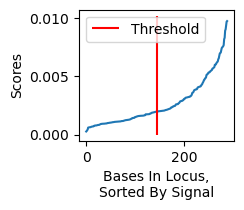

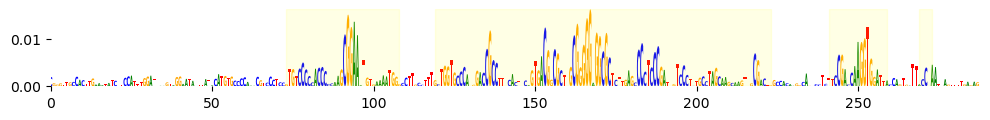

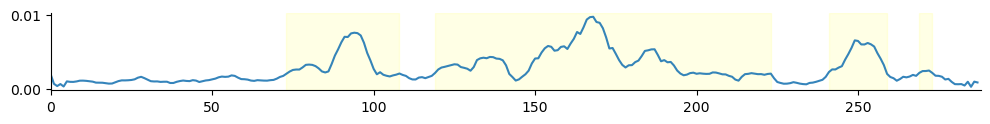

(344, 656)
Found 2 windows that cover signal:
Window 1: 28 to 37
Window 2: 54 to 203

Bounds containing all windows: 28 203
Length of region containing all windows: 175
Original region length: 312 

Fraction of bases in any window: 0.500
Fraction of all score magnitude captured within windows: 0.870


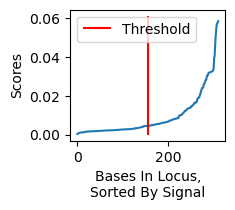

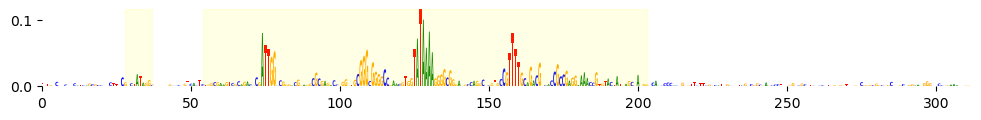

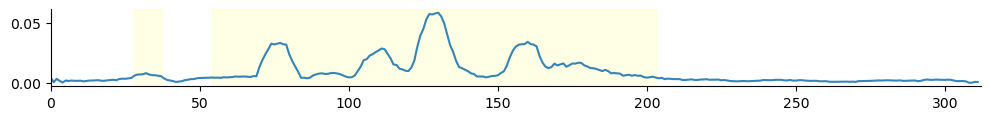

In [413]:
all_bounds_windows["dnase"]["profile_scores"] = get_all_score_bounds_windows(dnase_bounds_windows_pad,
                                                                             dnase_data["scores"]["profile"],
                                                                             onehot_seq)
all_bounds_windows["dnase"]["counts_scores"] = get_all_score_bounds_windows(dnase_bounds_windows_pad,
                                                                            dnase_data["scores"]["counts"],
                                                                            onehot_seq)
all_bounds_windows["procap"]["profile_scores"] = get_all_score_bounds_windows(procap_bounds_windows_pad,
                                                                              procap_data["scores"]["profile"],
                                                                              onehot_seq,
                                                                              frac_of_max_thresh = 0.1)

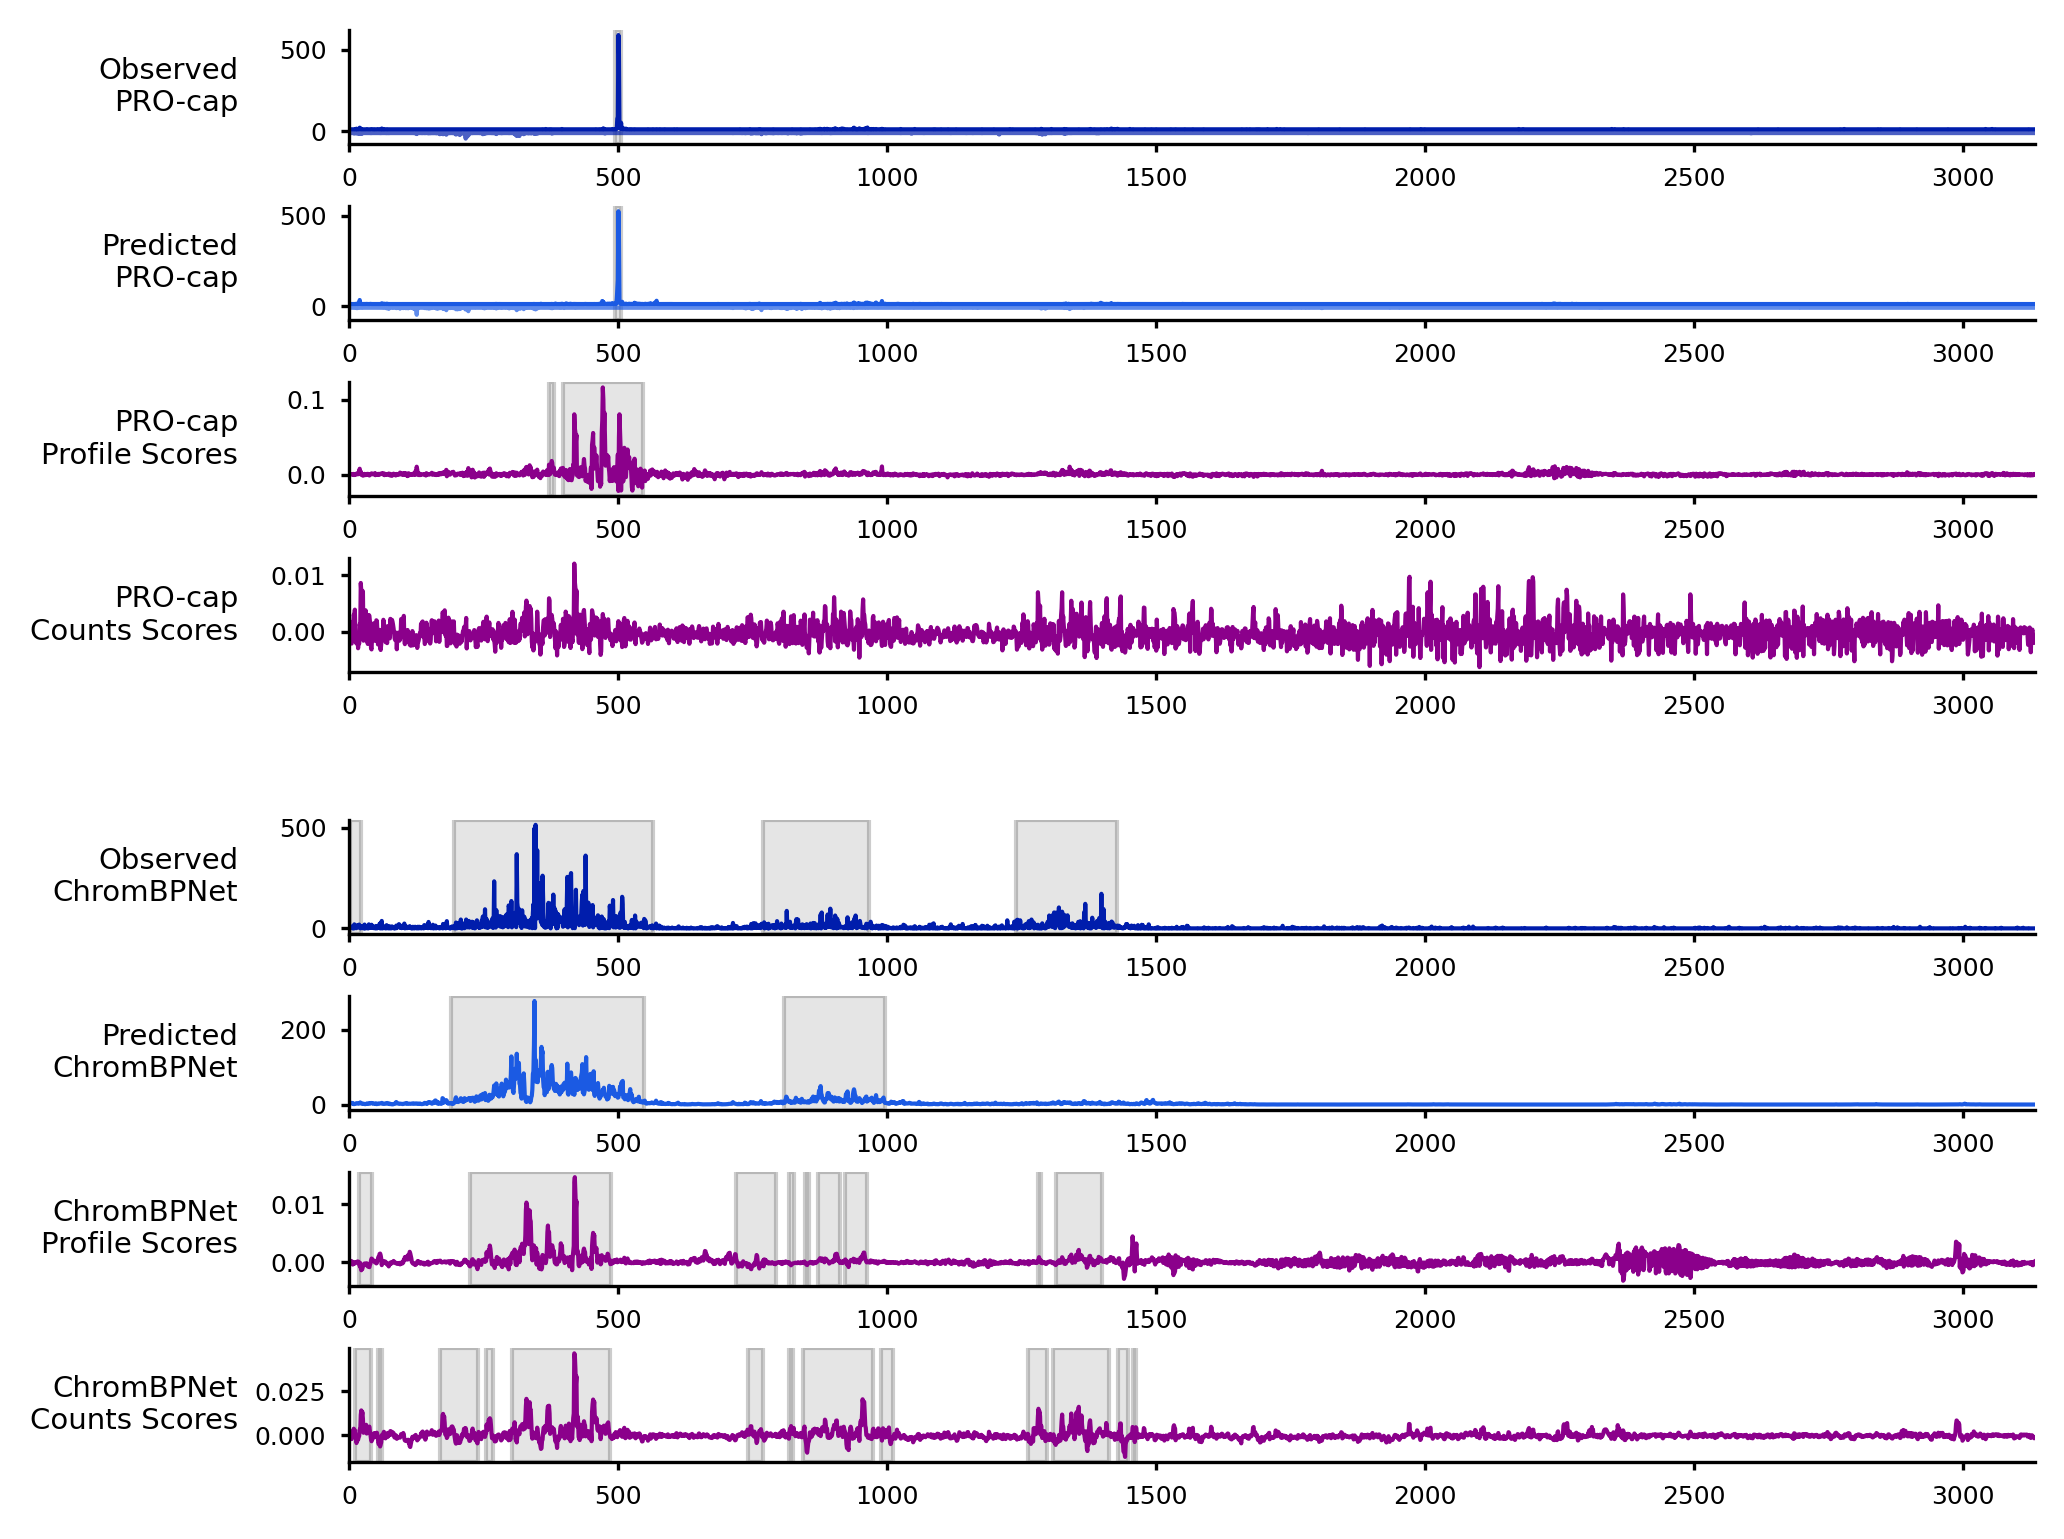

In [414]:
def highlight_window(start_pos, end_pos, ax, locus_len, height):
    rect = patches.Rectangle((start_pos, ax.get_ylim()[0]),
                             end_pos - start_pos, ax.get_ylim()[1] - ax.get_ylim()[0],
                             linewidth=1, edgecolor='k', facecolor='gray', alpha=0.2)
    ax.add_patch(rect)

    
def plot_bounds_windows(all_bounds_windows, axes, locus_len):
    axes_to_data_types = {0:["procap","obs_data"],1:["procap","preds"],
                          2:["procap", "profile_scores"],
                          5:["dnase","obs_data"],6:["dnase","preds"],
                          7:["dnase", "profile_scores"],8:["dnase", "counts_scores"]}
    
    for ax_i, (dnase_or_procap, data_type) in axes_to_data_types.items():
        bounds_windows = all_bounds_windows[dnase_or_procap][data_type]
        
        for bounds_window in bounds_windows:
            highlight_window(bounds_window[0], bounds_window[1], axes[ax_i],
                             locus_len, 5)


fig = plt.figure(figsize=(7.25, 6.2), dpi=300)
gs = fig.add_gridspec(9, height_ratios = [10] * 4 + [2] + [10] * 4, hspace=0.6)
axes = gs.subplots()

locus_len = max(onehot_seq.shape)

plot_tracks_for_expt(procap_data, onehot_seq, axes[:4], "PRO-cap")
plot_tracks_for_expt(dnase_data, onehot_seq, axes[5:], "ChromBPNet")
    
# aesthetics
for ax_i, ax in enumerate(axes):
    ax.tick_params(length=2, labelsize=6)
    ax.spines[["top", "right"]].set_visible(False)
    
erase_axis(axes[4])
    
fig.align_ylabels()


plot_bounds_windows(all_bounds_windows, axes, locus_len)

plt.show()